In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import ticker
from hera_cal import io, delay_filter
import hera_qm
from tqdm.notebook import tqdm
from pyuvdata import UVFlag
import scipy
import warnings
import pickle
import copy
import hera_pspec
import simpleqe as sqe
import matplotlib.gridspec as gridspec
import pandas as pd
from IPython.core.display import display, HTML

/users/jsdillon/lustre/tmp/ipykernel_2048/2621491830.py:18: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Array, Antenna Flagging, and Epochs Plots

In [2]:
nights = {}
flagged_nights = {}
total_ants_per_night = {}
flagged_ants_per_night = {}

yaml_files = sorted(glob.glob('/lustre/aoc/projects/hera/H1C_IDR3/IDR3_2/h1c_idr3_software/hera_pipelines/pipelines/h1c/idr3/v2/a_priori_flags/*.yaml'))

for yaml in tqdm(yaml_files):
    ant_flags = set(hera_qm.metrics_io.read_a_priori_ant_flags(yaml))
    JD = int(yaml.split('/')[-1].split('.')[0])
    auto_files = sorted(glob.glob(f'/lustre/aoc/projects/hera/H1C_IDR3/IDR3_2/{JD}/*autos.uvh5'))
    if len(auto_files) > 0:
        hd = io.HERAData(auto_files[-1])
        total_ants_per_night[JD] = len(hd.data_ants)
        flagged_ants_per_night[JD] = len([ant for ant in hd.data_ants if ant in ant_flags])
        for ant in hd.data_ants:
            if ant not in nights:
                nights[ant] = []
                flagged_nights[ant] = []
            nights[ant].append(JD)
            if ant in ant_flags:
                flagged_nights[ant].append(JD)


  0%|          | 0/107 [00:00<?, ?it/s]

In [3]:
def draw_pie(dist, xpos, ypos, size, ax):
    # for incremental pie slices
    cumsum = np.cumsum(dist)
    cumsum = cumsum/ cumsum[-1]
    pie = [0] + cumsum.tolist()

    if np.all(np.array(dist)[1:] == 0):
        ax.scatter([xpos], [ypos], marker='o', s=size, c='palegreen', ec='none')
    elif np.all(dist[0] == 0 and dist[2] == 0):
        ax.scatter([xpos], [ypos], marker='o', s=size, c='lightcoral', ec='none')
    else:
        for i, r1, r2, c in zip(range(len(pie)-1), pie[:-1], pie[1:], ['palegreen', 'lightcoral', 'w']):
            try:
                if pie[i] == pie[i+1]:
                    continue
            except:
                pass
            angles = np.linspace(2 * np.pi * r1, 2 * np.pi * r2)
            x = [0] + (np.sin(angles)).tolist()
            y = [0] + (np.cos(angles)).tolist()
            xy = np.column_stack([x, y])
            ax.scatter([xpos], [ypos], marker=xy, s=size, c=c, ec='none')
    ax.scatter([xpos], [ypos], marker='o', s=size, c='none', ec='grey')        

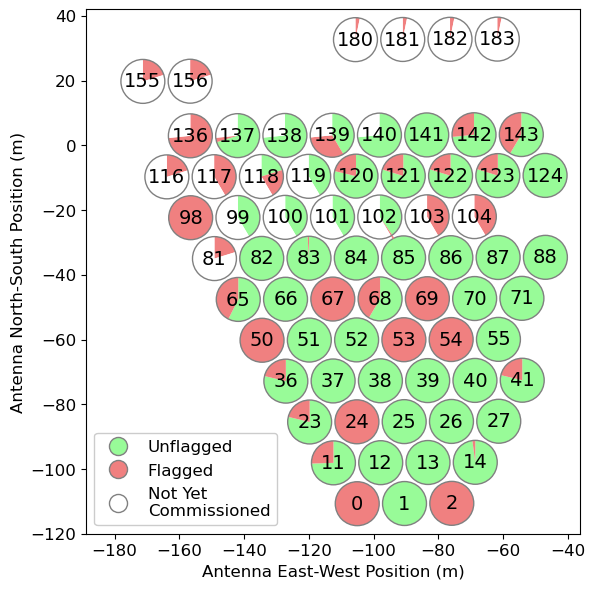

In [4]:
max_nights = np.max([len(nights[ant]) for ant in nights])

fig, ax = plt.subplots(figsize=(6,6), dpi=100)
for ant in nights:
    if ant > 200:
        continue
    pos = hd.antpos[ant]
    draw_pie([len(nights[ant]) - len(flagged_nights[ant]), len(flagged_nights[ant]), max_nights - len(nights[ant])], pos[0], pos[1], 1000, ax)
    
    plt.text(pos[0],pos[1],str(ant), va='center', ha='center', color='k', size=14)
    
    
legend_objs = []
legend_labels = []
legend_objs.append(matplotlib.lines.Line2D([0], [0], marker='o', color='w', markeredgecolor='grey', markerfacecolor='palegreen', markersize=13))
legend_labels.append(f'Unflagged')
legend_objs.append(matplotlib.lines.Line2D([0], [0], marker='o', color='w', markeredgecolor='grey', markerfacecolor='lightcoral', markersize=13))
legend_labels.append(f'Flagged')
legend_objs.append(matplotlib.lines.Line2D([0], [0], marker='o', color='w', markeredgecolor='grey', markerfacecolor='w', markersize=13))
legend_labels.append(f'Not Yet\nCommissioned')

plt.legend(legend_objs, legend_labels, ncol=1, fontsize=12, framealpha=1, loc='lower left')


plt.axis('equal')
plt.ylim([-120, 42])
plt.xlim([-180, -45])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Antenna East-West Position (m)', fontsize=12)
plt.ylabel('Antenna North-South Position (m)', fontsize=12)
plt.tight_layout()
plt.savefig('Array_Layout_And_Flagging.pdf')


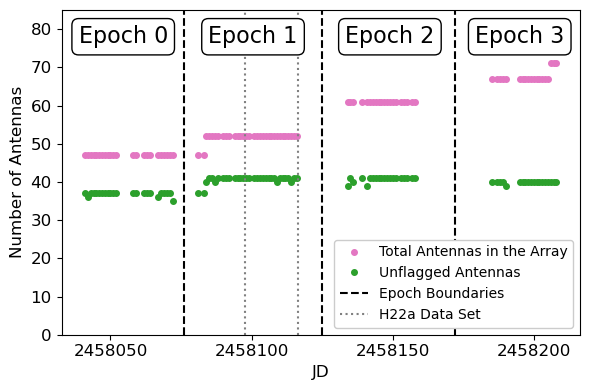

In [5]:
fig, ax = plt.subplots(figsize=(6,4), dpi=100)
JDs = sorted(list(total_ants_per_night.keys()))
nAnts = [total_ants_per_night[JD] for JD in JDs]
nUnflagged = [total_ants_per_night[JD] - flagged_ants_per_night[JD] for JD in JDs]

ax.plot(JDs, nAnts,'.', ms=8, color='C6', label='Total Antennas in the Array')
ax.plot(JDs, nUnflagged,'.', ms=8, color='C2', label='Unflagged Antennas')
ax.set_ylim([0, 85])
ax.set_ylabel('Number of Antennas', fontsize=12)
ax.set_xlabel('JD', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xticks([2458050, 2458100, 2458150, 2458200], [2458050, 2458100, 2458150, 2458200])

for i, epoch_boundary in enumerate([2458076, 2458125, 2458172]):
    ax.axvline(epoch_boundary, c='k', ls='--', label=('Epoch Boundaries' if i == 0 else None))

ax.axvline(2458097.5, c='grey', ls=':', label='H22a Data Set')    
ax.axvline(2458116.5, c='grey', ls=':')    
    
for i, epoch_center in enumerate([2458054.5, 2458100.5, 2458149, 2458195]):
    ax.text(epoch_center, 78, f'Epoch {i}', ha='center', va='center', fontsize=16, bbox={'ec': 'k', 'fc': 'w', 'boxstyle': 'round'})
    
ax.legend(framealpha=1, loc='lower right')
plt.tight_layout()
plt.savefig('Antennas_And_Epochs.pdf')

# Flagging Waterfalls, Occupancy, and Bands

In [6]:
spw_ranges = [[176, 340], [535, 697]] # these can be found in the pspec histories
hand_flag_files = glob.glob('/lustre/aoc/projects/hera/H1C_IDR3/IDR3_2/LSTBIN/all_epochs/*hand_flags.h5')
hand_flag_files = sorted(hand_flag_files, key=lambda f: np.mean(UVFlag(f).time_array))
uvf = UVFlag(hand_flag_files)
lsts = np.unwrap(uvf.lst_array) * 12 / np.pi
while np.max(lsts) > 24:
    lsts -= 24
freqs = uvf.freq_array / 1e6

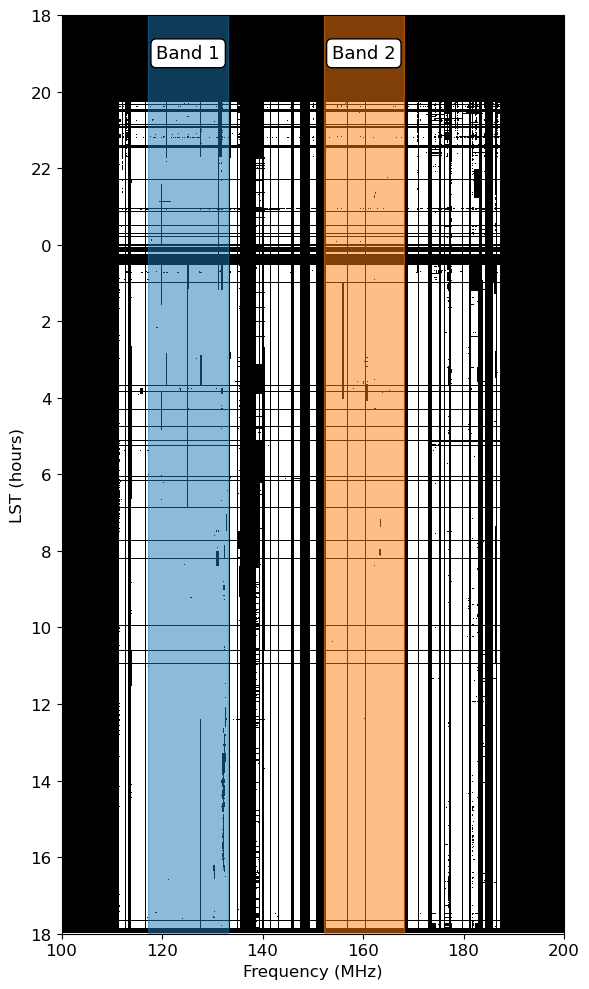

In [7]:
plt.figure(figsize=(6,10), dpi=100)
plt.imshow(uvf.flag_array.squeeze(), aspect='auto', interpolation='none', cmap='binary',
           extent=[freqs[0], freqs[-1], lsts[-1], lsts[0]])

for band, spwr, color in zip([1, 2], spw_ranges, ['C0', 'C1']):
    plt.axvspan(freqs[spwr[0]], freqs[spwr[1]], color=color, alpha=.5)
    plt.text(np.mean([freqs[spwr[0]], freqs[spwr[1]]]), -5, f'Band {band}', 
             bbox=dict(facecolor='w', alpha=1, boxstyle='round'), va='center', ha='center', fontsize=13)

plt.yticks(ticks=np.arange(-6, 20, 2), labels=(np.arange(-6, 20, 2) % 24));
plt.xticks(np.linspace(100, 200, 6))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Frequency (MHz)', fontsize=12)
plt.ylabel('LST (hours)', fontsize=12)
plt.tight_layout()
plt.savefig(f'flag_waterfall.pdf')

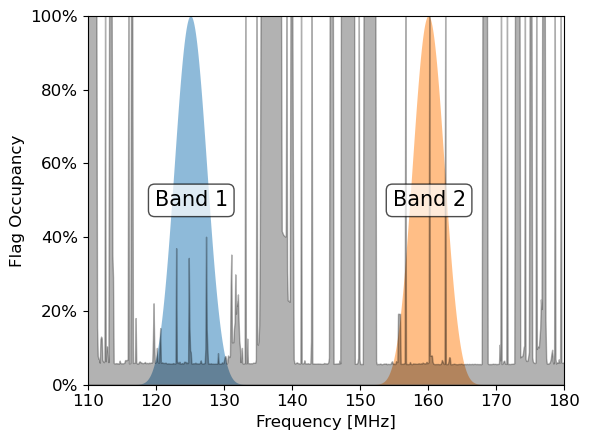

In [8]:
plt.figure(figsize=(6,4.5), dpi=100)
unflagged_time_inds = np.arange(uvf.flag_array.shape[0])[~np.all(uvf.flag_array.squeeze(), axis=1)]
flag_time_subset = uvf.flag_array[np.min(unflagged_time_inds):(np.max(unflagged_time_inds) + 1), :, 0]

for band, spwr, color in zip([1, 2], spw_ranges, ['C0', 'C1']):
    bh = 100 * scipy.signal.blackmanharris(spwr[1]-spwr[0])
    plt.fill_between(freqs[spwr[0]:spwr[1]], bh,  alpha=.5)
    plt.text(np.mean([freqs[spwr[0]], freqs[spwr[1]]]), 50, f'Band {band}', 
             bbox=dict(facecolor='w', alpha=.7, boxstyle='round'), va='center', ha='center', fontsize=15)
    

plt.fill_between(freqs, 100 * np.mean(flag_time_subset, axis=0), alpha=.3, color='k', edgecolor='k', linewidth=1)
plt.ylabel('Flag Occupancy', fontsize=12)
plt.xlabel('Frequency [MHz]', fontsize=12)
plt.xlim([110, 180])
plt.ylim([0, 100])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

import matplotlib.ticker as mtick

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.tight_layout()

plt.savefig(f'flag_occupancy_with_bands.pdf', dpi=200)

# Cross-Talk Plots

In [9]:
# load data that's been LST-binned for all four epochs without any cross-talk removal
bl_to_plot = (11, 66, 'nn')
spw = 0
all_epochs_files = [hf.replace('.hand_flags.h5', '.uvh5') for hf in hand_flag_files]
warnings.filterwarnings("ignore", message="antenna_diameters is not set. Using known values for HERA.")
hd_all = io.HERAData(all_epochs_files)
hd_all.read(bls=[bl_to_plot], axis='blt');

# inpaint out to 4000 ns
F_all = delay_filter.DelayFilter(hd_all)
F_all.vis_clean(data=F_all.data, flags=F_all.flags, ax='freq', horizon=1.0, standoff=50.0, min_dly=4000.0, 
                window='tukey', alpha=.15, edgecut_low=100, edgecut_hi=150, tol=1.0e-05, skip_wgt=.2, maxiter=100,
                gain=.9, overwrite=True, verbose=False, output_prefix='clean', add_clean_residual=False, zeropad=256)
# FFT
F_all.fft_data(data=F_all.clean_data, assign='dfft0', ax='freq', window='bh', edgecut_low=100, edgecut_hi=624, overwrite=True)
F_all.fft_data(data=F_all.clean_data, assign='dfft1', ax='freq', window='bh', edgecut_low=400, edgecut_hi=150, overwrite=True)

# handle phase wraps in LST
lsts = np.unwrap(F_all.lsts)*12/np.pi
while np.max(lsts) > 24:
    lsts -= 24

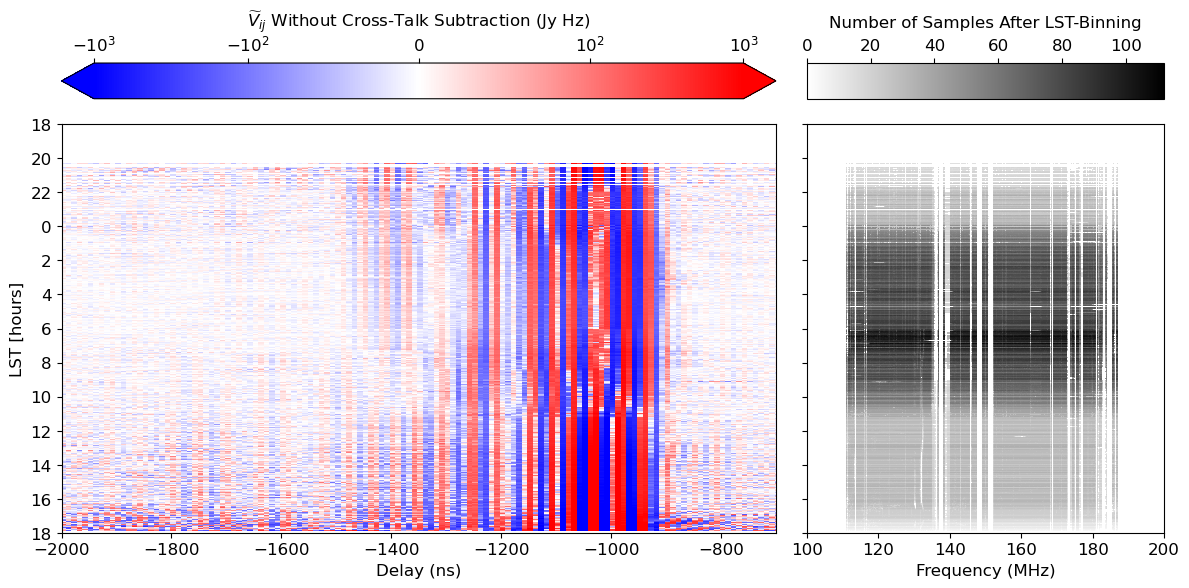

In [10]:
fig, axes = plt.subplots(1,2, figsize=(12,6), dpi=100, sharey=True, gridspec_kw={'hspace': 0, 'width_ratios': [2, 1]})
im = axes[0].imshow(np.where(np.all(F_all.flags[bl_to_plot], axis=1, keepdims=True), np.nan, 
                             np.real([F_all.dfft0[bl_to_plot], F_all.dfft1[bl_to_plot]][spw])), 
                    aspect='auto', cmap='bwr', norm=matplotlib.colors.SymLogNorm(100, vmax=1e3, vmin=-1e3),
                    interpolation='none', extent=[F_all.delays[0], F_all.delays[-1], lsts[-1], lsts[0]])
axes[0].set_xlabel('Delay (ns)', fontsize=12)
axes[0].set_xlim([-2000, -700])
cbar = plt.colorbar(im, ax=axes[0], location='top', extend='both')
cbar.set_label(r'$\widetilde{V}_{ij}$ Without Cross-Talk Subtraction (Jy Hz)', fontsize=12)#, labelpad=12)
cbar.ax.tick_params(labelsize=12)

im = axes[1].imshow(F_all.nsamples[bl_to_plot] * ~F_all.flags[bl_to_plot], cmap='binary', aspect='auto', interpolation='none',
                    extent=[F_all.freqs[0] / 1e6, F_all.freqs[-1] / 1e6, lsts[-1], lsts[0]])
axes[1].set_xlim([100,200])
axes[1].set_xlabel('Frequency (MHz)', fontsize=12)
cbar = plt.colorbar(im, ax=axes[1], aspect=10, location='top')
cbar.set_label('Number of Samples After LST-Binning', fontsize=12, labelpad=8)
cbar.ax.tick_params(labelsize=12)#, direction='out', size=4)

for ax in axes:
    ax.set_yticks(np.arange(-6, 20, 2))
    ax.tick_params(labelsize=12)
axes[0].set_yticklabels(np.arange(-6, 20, 2) % 24)
axes[0].set_ylabel('LST [hours]', fontsize=12)


plt.tight_layout()
plt.savefig(f'crosstalk_discontinuities.png', dpi=300, bbox_inches='tight')

# LST Coverage and Definition of Fields

In [11]:
# figure out the correct order of files, based on a split at 4.71 radians
def file_lst_for_sort(fn):
    lst = float(fn.split('.LST.')[-1].split('.sum.')[0]) - 4.71
    if lst < 0:
        lst += 2 * np.pi
    return lst
# figure out the correct order of files, based on a split at 4.71 radians
def file_lst_for_sort2(fn):
    lst = float(fn.split('.LST.')[-1].split('.HH.')[0]) - 4.71
    if lst < 0:
        lst += 2 * np.pi
    return lst


all_epochs_files = sorted(glob.glob('/lustre/aoc/projects/hera/H1C_IDR3/IDR3_2/LSTBIN/all_epochs_preprocessed/zen.grp1.of1.LST.*.sum.LPL.uvh5'), key=file_lst_for_sort)
idr2_files = sorted(glob.glob(f'/lustre/aoc/projects/hera/H1C_IDR2/IDR2_2/LSTBIN/one_group/grp1/zen.grp1.of1.LST.*.uvh5'), key=file_lst_for_sort2)

# load single baseline for all 
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    hd_idr2 = io.HERAData(idr2_files)
    data_idr2, flags_idr2, nsamples_idr2 = hd_idr2.read(bls=[(25,26,'ee')], axis='blt')    
    
    hd_idr3 = io.HERAData(all_epochs_files)
    data_idr3, flags_idr3, nsamples_idr3 = hd_idr3.read(bls=[(25,26,'ee')], axis='blt')

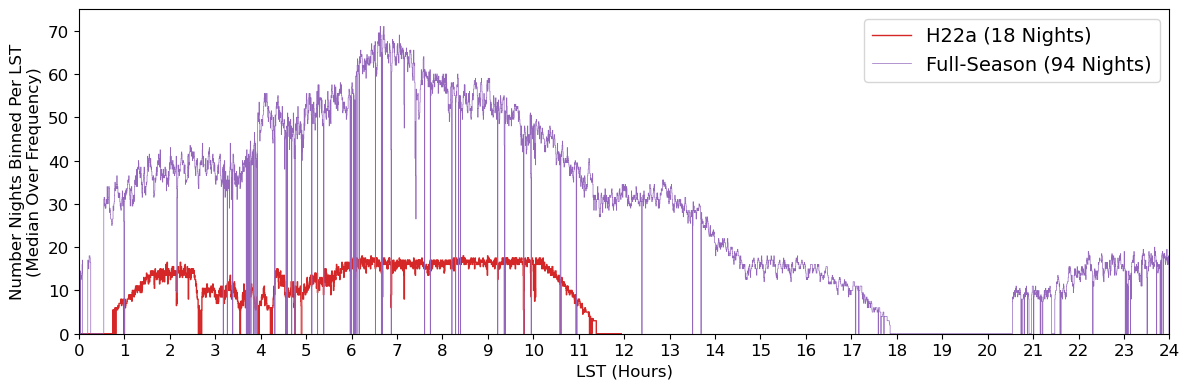

In [12]:
plt.figure(figsize=(12,4), dpi=100)
bl = (25,26,'ee')
nights_per_lst2 = np.nanmedian(np.where(np.all(nsamples_idr2[bl] == 0, axis=0)[np.newaxis, :], np.nan, nsamples_idr2[bl]) / 2, axis=1)
nights_per_lst3 = np.nanmedian(np.where(np.all(nsamples_idr3[bl] == 0, axis=0)[np.newaxis, :], np.nan, nsamples_idr3[bl]) / 2, axis=1)

plt.step(nsamples_idr2.lsts * 12 / np.pi, nights_per_lst2, lw=1, c='C3', label='H22a (18 Nights)')
plt.step(nsamples_idr3.lsts[nsamples_idr3.lsts > 4.71] * 12 / np.pi, nights_per_lst3[nsamples_idr3.lsts > 4.71], lw=.5, c='C4', label='Full-Season (94 Nights)')
plt.step(nsamples_idr3.lsts[nsamples_idr3.lsts < 4.71] * 12 / np.pi, nights_per_lst3[nsamples_idr3.lsts < 4.71], lw=.5, c='C4')

plt.ylabel('Number Nights Binned Per LST\n(Median Over Frequency)', fontsize=12)
plt.xlim([0, 24])
plt.ylim([0, 75])
plt.xticks(np.arange(0, 25), fontsize=12)
plt.yticks(np.arange(0, np.max(nights_per_lst3), 10), fontsize=12)
plt.xlabel('LST (Hours)', fontsize=12)
plt.legend(fontsize=14)

plt.tight_layout()
plt.savefig('lst_coverage_comparison.pdf')

In [13]:
fields_plot_npz = np.load('../All_Epochs_Power_Spectra/figures/fields_vs_noise_and_power_data.npz')
fields_plot_data = {k: np.where(fields_plot_npz[k] == 0, np.nan, fields_plot_npz[k]) for k in fields_plot_npz}

# LST ranges of fields
lstcuts = [(-2.5, 0), # Field A
           (0.75, 2.75), # Field B
           (4, 6.25), # Field C
           (6.25, 9.25), # Field D
           (9.25, 14.75),  # Field E
          ]
lst_colors = ['limegreen', 'gold', 'cyan', 'deeppink', 'mediumorchid', 'aquamarine']

Casting complex values to real discards the imaginary part


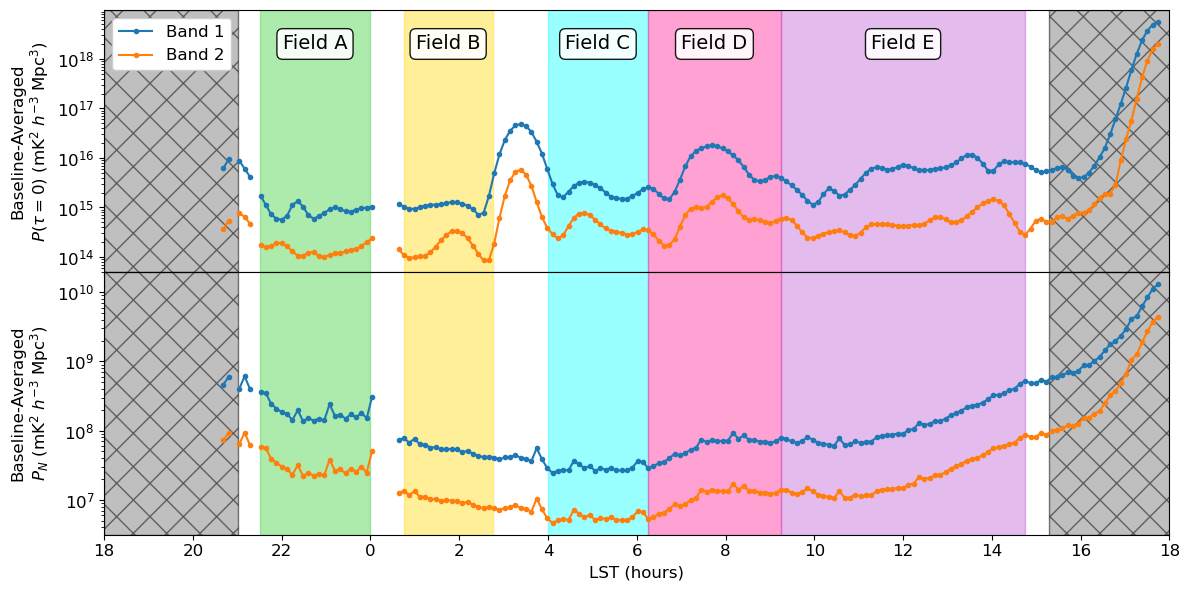

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(12,6), sharex=True, gridspec_kw={'hspace': 0}, dpi=100)

axes[0].semilogy(fields_plot_data['lsts_wrapped'], fields_plot_data['bl_avg_pspec_tau0_b1'], '.-', label=f'Band 1')
axes[0].semilogy(fields_plot_data['lsts_wrapped'], fields_plot_data['bl_avg_pspec_tau0_b2'], '.-', label=f'Band 2')
axes[0].set_ylabel('Baseline-Averaged\n'+r'$P(\tau = 0)\ ({\rm mK}^2\ h^{-3}\ {\rm Mpc}^3)$', fontsize=12)

for field, (lc, c) in enumerate(zip(lstcuts, lst_colors)):
    axes[0].axvspan(lc[0], lc[1], color=c, alpha=.4)
    axes[0].text(np.mean(lc), 2e18, f'Field {"ABCDEFGHIJ"[field]}', ha='center', va='center', fontsize=14, bbox=dict(facecolor='w', alpha=0.9, boxstyle='round'))

    
axes[1].semilogy(fields_plot_data['lsts_wrapped'], fields_plot_data['bl_avg_noise_b1'], '.-', label=f'Band 1')
axes[1].semilogy(fields_plot_data['lsts_wrapped'], fields_plot_data['bl_avg_noise_b2'], '.-', label=f'Band 2')    
axes[1].set_ylabel('Baseline-Averaged\n'+r'$P_N\ ({\rm mK}^2\ h^{-3}\ {\rm Mpc}^3)$', fontsize=12)

for lc, c in zip(lstcuts, lst_colors):
    axes[1].axvspan(lc[0], lc[1], color=c, alpha=.4)    
axes[1].set_xlabel('LST (hours)', fontsize=12)  

for ax in axes:
    ax.tick_params(axis='y', labelsize=12)
    ax.set_xticks(np.arange(-6, 20, 2), fontsize=12)
    ax.set_xlim([-6,18])
    poly = ax.axvspan(-6, 24 * 5.5/2/np.pi - 24, color='grey', alpha=.5)
    poly.set_hatch('X')
    poly.set_edgecolor('k')
    poly = ax.axvspan(24 * 4/2/np.pi, 19, color='grey',alpha=.5)    
    poly.set_hatch('X')    
    poly.set_edgecolor('k')
axes[1].set_xticklabels(np.arange(-6, 20, 2) % 24, fontsize=12)

axes[0].legend(loc='upper left', framealpha=1, fontsize=12)


plt.tight_layout()
plt.savefig('fields_vs_noise_and_power.pdf')

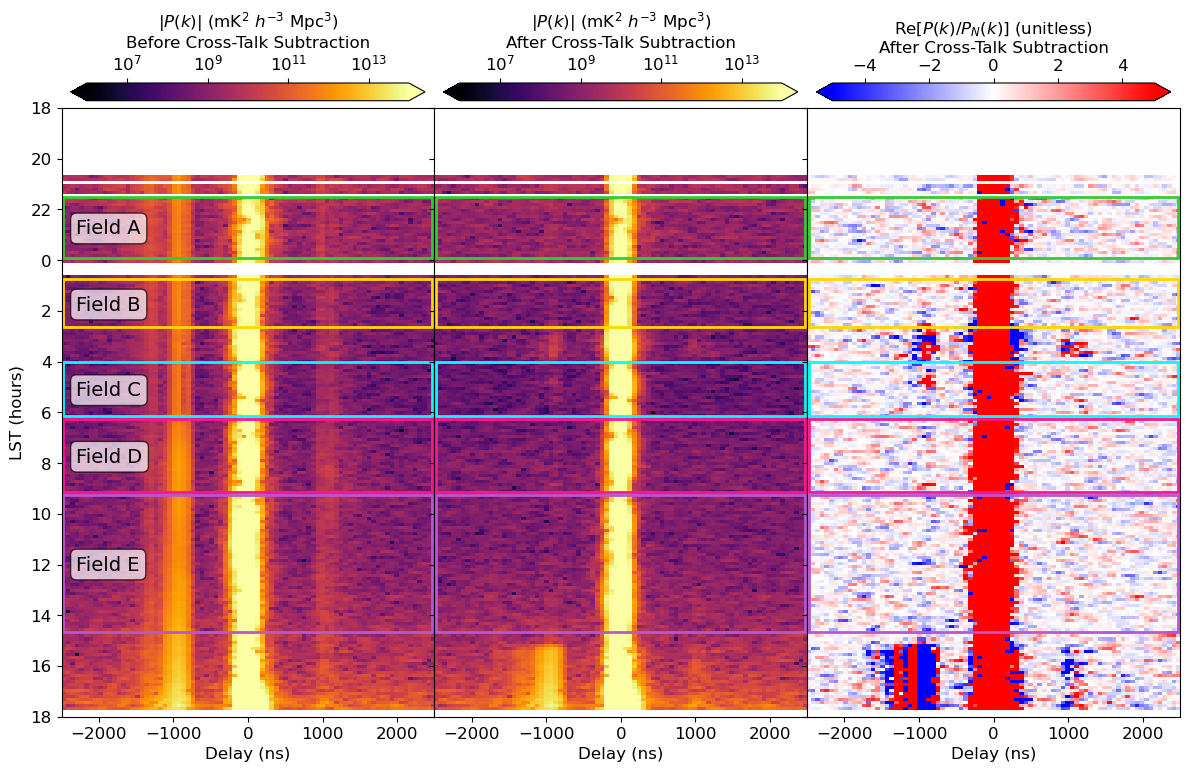

In [15]:
blp = ((38, 66), (52, 82))

spw = 0

uvp_xtk = hera_pspec.UVPSpec()
uvp_xtk.read_hdf5(f'../All_Epochs_Power_Spectra/figures/pspec_waterfall_{"_".join([str(ant) for bl in blp for ant in bl])}_xtk.hdf5')
uvp_tk = hera_pspec.UVPSpec()
uvp_tk.read_hdf5(f'../All_Epochs_Power_Spectra/figures/pspec_waterfall_{"_".join([str(ant) for bl in blp for ant in bl])}_tk.hdf5')


lst_indexes = np.unique(uvp_xtk.lst_1_array, return_index=True)[1]
lsts_wrapped = np.unwrap([uvp_xtk.lst_avg_array[i] for i in sorted(lst_indexes)]) * 12 / np.pi - 24
dlys = np.unique(uvp_xtk.dly_array)
extent = [dlys[0]*1e9, dlys[-1]*1e9, lsts_wrapped[-1], lsts_wrapped[0]]
key = (spw, blp, ('pI', 'pI'))

shrink=.95

fig, axes = plt.subplots(1,3, figsize=(12,8), dpi=100, sharey=True, gridspec_kw={'wspace': .0})

im = axes[0].imshow(np.where(~np.isfinite(uvp_tk.get_stats('P_N', key)), np.nan, np.abs(uvp_tk.get_data(key))), 
                               norm=matplotlib.colors.LogNorm(vmin=1e6, vmax=1e14), 
                               aspect='auto', interpolation='none', cmap='inferno', extent=extent)
cbar = plt.colorbar(im, ax=axes[0], location='top', extend='both', shrink=shrink, pad=.01)
cbar.set_label(r'$|P(k)|$ (${\rm mK}^2\ h^{-3}\ {\rm Mpc}^3$)' + '\nBefore Cross-Talk Subtraction', fontsize=12)#, labelpad=12)
cbar.ax.tick_params(labelsize=12)
axes[0].set_ylabel('LST (hours)', fontsize=12)


im = axes[1].imshow(np.where(~np.isfinite(uvp_xtk.get_stats('P_N', key)), np.nan, np.abs(uvp_xtk.get_data(key))), 
                               norm=matplotlib.colors.LogNorm(vmin=1e6, vmax=1e14), 
                               aspect='auto', interpolation='none', cmap='inferno', extent=extent)
cbar = plt.colorbar(im, ax=axes[1], location='top', extend='both', shrink=shrink, pad=.01)
cbar.set_label(r'$|P(k)|$ (${\rm mK}^2\ h^{-3}\ {\rm Mpc}^3$)' + '\nAfter Cross-Talk Subtraction', fontsize=12)#, labelpad=12)
cbar.ax.tick_params(labelsize=12)


im = axes[2].imshow(np.real(uvp_xtk.get_data(key) / uvp_xtk.get_stats('P_N', key)),
                    aspect='auto', interpolation='none', extent=extent, cmap='bwr', vmin=-5, vmax=5)
cbar = plt.colorbar(im, ax=axes[2], location='top', extend='both', shrink=shrink, pad=.01)
cbar.set_label(label='Re$[P(k) / P_N(k)]$ (unitless)'+ '\nAfter Cross-Talk Subtraction', fontsize=12)
cbar.ax.tick_params(labelsize=12)

for ax in axes:
    ax.set_yticks(np.arange(-6, 20, 2))
    axes[0].set_yticklabels(np.arange(-6, 20, 2) % 24)
    ax.tick_params(labelsize=12)
    ax.set_xlabel('Delay (ns)', fontsize=12)
    ax.set_xlim([-2500, 2500])
    for i, lc in enumerate(lstcuts):
        r = plt.Rectangle((-2475, lc[0]), 4950, lc[1]-lc[0]-.1, fc='None', ec=lst_colors[i], lw=2)
        ax.add_patch(r)
        if ax == axes[0]:
            ax.text(-2300, np.mean(lc), f"Field {'ABCDEFGHIJ'[i]}", fontsize=14, 
                    bbox=dict(facecolor='w', alpha=0.7, boxstyle='round'), c='k', ha='left', va='center')

plt.tight_layout()
plt.savefig('power_spectrum_waterfall_with_xtalk_subtraction.png', dpi=300, bbox_inches='tight')

In [36]:
import pickle
with open('../All_Epochs_Power_Spectra/figures/crosstalk_flagging_plot_variables.p', 'rb') as f:
    xtalk_vars = pickle.load(f)    
    
flag_neg_delays = xtalk_vars['flag_neg_delays']
flag_pos_delays = xtalk_vars['flag_pos_delays']
flag_all_delays = xtalk_vars['flag_all_delays']
xtalk_dly_min = xtalk_vars['xtalk_dly_min']
xtalk_dly_max = xtalk_vars['xtalk_dly_max']
high_dly_diff = xtalk_vars['high_dly_diff']
auto_xtalk_snrs = xtalk_vars['auto_xtalk_snrs']
auto_high_dly_snrs = xtalk_vars['auto_high_dly_snrs']
auto_xtalk_snr_cut = xtalk_vars['auto_xtalk_snr_cut']    

Band 1 Negative Delays:
3.5% of auto-baseline pairs flagged
(corresponding to 8.9% of 
cross-baseline pairs flagged)
Band 1 Positive Delays:
1.0% of auto-baseline pairs flagged
(corresponding to 3.9% of 
cross-baseline pairs flagged)
Band 2 Negative Delays:
3.8% of auto-baseline pairs flagged
(corresponding to 6.5% of 
cross-baseline pairs flagged)
Band 2 Positive Delays:
0.9% of auto-baseline pairs flagged
(corresponding to 3.0% of 
cross-baseline pairs flagged)


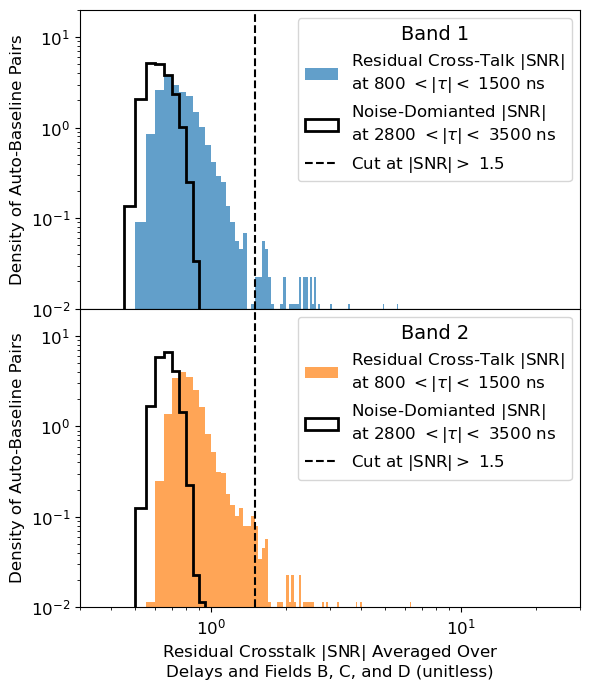

In [113]:
fig, axes = plt.subplots(2, 1, figsize=(6,7), dpi=100, gridspec_kw={'hspace': 0})

# for axis, fname in zip(axes, ['neg', 'pos']):

for spw, ax in enumerate(axes):
    
    for fname in ['neg', 'pos']:        
        flag_delays = [flag_neg_delays, flag_pos_delays][fname == 'pos']
        auto_flags_here = [flag_delays[k] for k in flag_delays if (k[0] == spw) and (k[1][0] == k[1][1])]
        cross_flags_here = [flag_delays[k] for k in flag_delays if (k[0] == spw) and (k[1][0] != k[1][1])]

        title = f'Band {spw + 1} {["Negative", "Positive"][fname == "pos"]} Delays:\n'
        title += f'{100 * np.sum(auto_flags_here) / len(auto_flags_here):.1f}% of auto-baseline pairs flagged\n'
        title += f'(corresponding to {100 * np.sum(cross_flags_here) / len(cross_flags_here):.1f}% of \ncross-baseline pairs flagged)'
        print(title)

        

    label = f'Band {spw+1} Flags:\n'

    label1 = f'Residual Cross-Talk $|$SNR$|$\nat {xtalk_dly_min} ' + '$<|\\tau| <$' + f' {xtalk_dly_max} ns'
    label2 = f'Noise-Domianted $|$SNR$|$\nat {xtalk_dly_min + high_dly_diff} ' + '$<|\\tau| <$' + f' {xtalk_dly_max + high_dly_diff} ns'


    ax.hist(np.append(auto_xtalk_snrs['neg'][spw], auto_xtalk_snrs['pos'][spw]),
            bins=np.arange(.4,10,.05), density=True, alpha=.7, color=['C0', 'C1'][spw], label=label1)        
    ax.hist(np.append(auto_high_dly_snrs['neg'][spw], auto_high_dly_snrs['pos'][spw]),
            bins=np.arange(.4,10,.05), density=True, histtype='step', lw=2, color='k', label=label2)

    ax.set_ylabel('Density of Auto-Baseline Pairs', fontsize=12)
    

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim([.3, 30])
    ax.set_ylim([1e-2, 20])
    ax.tick_params(labelsize=12)
    v2 = ax.axvline(auto_xtalk_snr_cut, linestyle='--', color='k', label='Cut at $|$SNR$|  >$ ' + f'{auto_xtalk_snr_cut:.1f}')

    title = f'Band {spw + 1}'

    ax.legend()
    handles, labels = ax.get_legend_handles_labels()
    order = [0, 1, 2]
    legend = ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title=title, fontsize=12)
    plt.setp(legend.get_title(),fontsize=14)

axes[1].set_xlabel(f'Residual Crosstalk $|$SNR$|$ Averaged Over\nDelays and Fields B, C, and D (unitless)', fontsize=12)    
    
plt.tight_layout()
plt.savefig(f'auto_xtalk_SNR_hist.pdf')

In [66]:
import pickle
with open('../All_Epochs_Power_Spectra/figures/residual_xtalk.p', 'rb') as f:
    res_xtalk_dict = pickle.load(f)    
    
SNRs = res_xtalk_dict['SNRs']
blvecs = res_xtalk_dict['blvecs']
blps = res_xtalk_dict['blps']

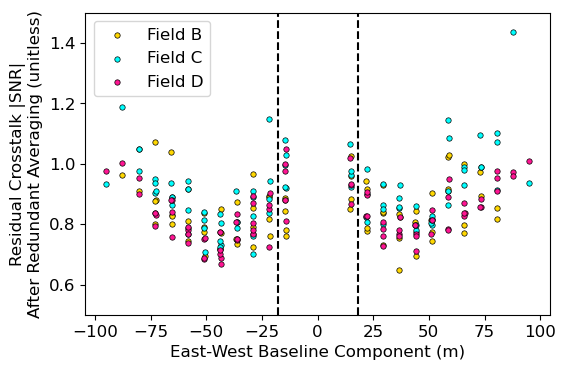

In [121]:
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=100)

for i, lstcut in enumerate(lstcuts):
    if i == 0 or i == 4:
        continue
    snr_array = []
    ew_comps = []
    for n, (blp, blvec) in enumerate(zip(blps, blvecs)):
        key=(spw, blp, ('pI', 'pI'))        
        snr_array.append(SNRs[key][lstcut])
        ew_comps.append(blvec[0])

    ax.scatter(ew_comps, snr_array, s=15, ec='k', linewidths=.5, c=lst_colors[i], label=f'Field {"ABCDE"[i]}')
    
ax.axvline(-18, ls='--', c='k')
ax.axvline(18, ls='--', c='k')
ax.tick_params(labelsize=12)
ax.set_ylim([.5, 1.5])
ax.set_xlabel('East-West Baseline Component (m)', fontsize=12)
ax.set_ylabel('Residual Crosstalk |SNR|\nAfter Redundant Averaging (unitless)', fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.savefig(f'residual_xtalk_vs_baseline.pdf')

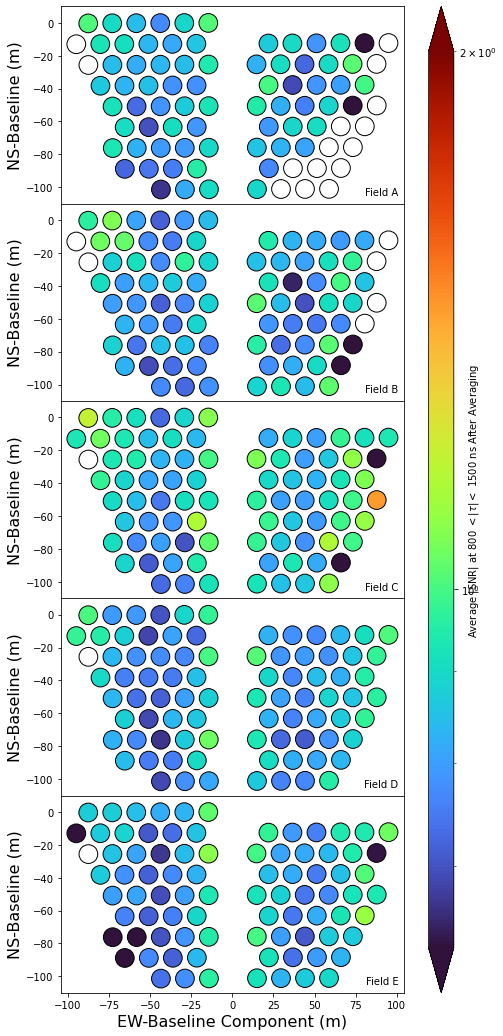

In [40]:
fig, axes = plt.subplots(len(lstcuts), 1, figsize=(7,14.5), sharex=True, gridspec_kw={'hspace': 0})

for i, lstcut in enumerate(lstcuts):
    ax = axes.flatten()[i]
    avg_snrs = np.array([])
    for n, (blp, blvec) in enumerate(zip(blps, blvecs)):

        if SNRs[key][lstcut] == 0:
            avg_snrs = np.append(avg_snrs, 0)
        else:
            avg_snrs = np.append(avg_snrs, SNRs[key][lstcut])
    scatter = ax.scatter(blvecs[:,0], blvecs[:,1], c=avg_snrs, s=350, cmap='turbo', edgecolors='k', norm=matplotlib.colors.LogNorm())
    scatter.set_clim([.63, 2])
    ax.set_aspect('equal')
    ax.set_ylim([-110, 10])
    if i == (len(lstcuts) - 1):
        ax.set_xlabel('EW-Baseline Component (m)', fontsize=16)
        
    ax.set_ylabel('NS-Baseline (m)', fontsize=16)
    ax.text(101, -103, f'Field {"ABCDEFGHIJ"[i]}', va='center', ha='right')#, bbox=dict(facecolor='w', alpha=0.8))

plt.tight_layout()
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.8, axes[-1].get_position().extents[1], 0.05, 
                        axes[0].get_position().extents[-1] - axes[-1].get_position().extents[1]])
cbar = fig.colorbar(scatter, cax=cbar_ax,  extend='both')
cbar.set_label(label='Average $|$SNR$|$ at ' + f'{xtalk_dly_min}' + ' $<|\\tau |<$ ' + f'{xtalk_dly_max} ns After Averaging', labelpad=-30)
    
# plt.savefig(f'{figures_folder}/{prefix}redundant_avg_xtalk_SNR_band_{spw+1}.pdf', dpi=200)

# 2D Power Spectra

In [16]:
with open('../All_Epochs_Power_Spectra/figures/uvp_xtk_tavg.p', 'rb') as f:
    uvp_xtk_tavg = pickle.load(f)
    
fields_used = [0, 1, 2, 3, 4]
wedge_buff_ns = 300

In [17]:
def wedge_plot(uvp, ax, spw, loglog=True, log10=True, fold=True, xlim=(5.0e-3, 6.1e-2), cmap='Spectral_r',
               ylim=(1.5e-2, 2.8e0), polpair=('pI', 'pI'), cbax=None, twiny=True, bl_label=True, twinx=True, dly_label=True, red_tol=0.1,
               component='real', fontsize=20, **kwargs):
    """
    Augmented wedge plotter, based off of hera_pspec.plot.delay_wedge

    Args:
        uvp : UVPSpec object
        **

    Returns:
       ax2, ax3 : axis objects of twin axes

    Note:
        To access colorbar, use ax.collections[0].colorbar 
    """
    freqs = uvp.get_spw_ranges(spw)[0][:2]
    z = uvp.cosmo.f2z(np.mean(uvp.get_spw_ranges(spw)[0][:2]))
    t2k = uvp.cosmo.tau_to_kpara(z, little_h=True) / 1e9

    hera_pspec.plot.delay_wedge(uvp, spw, polpair, log10=log10, ax=ax, fold=fold, rotate=True,
                                horizon_lines=False, red_tol=red_tol, colorbar=cbax is not None,
                                cbax=cbax, cmap=cmap, delay=False,
                                loglog=loglog, component=component, **kwargs)
    ax.tick_params(labelsize=16, size=8, direction='in', width=1, pad=10)
    ax.tick_params(which='minor', size=4, direction='in', width=1)
    if cbax is not None:
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=16)

#     x = np.linspace(5, 140, 100)
#     k = x * uvp.cosmo.bl_to_kperp(z)
#     y = x / 2.99e8 * t2k * 1e9
#     ax.plot(k, y + .0, color='grey', ls='--', lw=2.5)
    #ax.plot(k, y + np.diff(uvp.dly_array)[0] * 1e9 * t2k * 2, color='w', ls='--', lw=3)
    #ax.text(5.2e-3, 0.9e-1, "horizon", fontsize=18, rotation=0, c='w')

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(r'$k_{\perp}\ (h\ {\rm Mpc}^{-1}$)', fontsize=fontsize)
    ax.set_ylabel(r'$k_{\parallel}\ (h\ {\rm Mpc}^{-1}$)', fontsize=fontsize)

    ax2 = None
    if twiny:
        ax2 = ax.twiny()
        if loglog:
            ax2.set_xscale('log')
        ax2.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
        ax2.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:.1f}"))
        ax2.set_xlim(*np.array(ax.get_xlim()) / uvp.cosmo.bl_to_kperp(z))
        ax2.tick_params(which='major', length=8, direction='in', width=1, labelsize=16)
        ax2.tick_params(which='minor', length=4, direction='in', width=1, labelsize=16)
        if bl_label:
            ax2.set_xlabel(r"$|b|$ (m)", fontsize=fontsize, labelpad=10)
        else:
            ax2.set_xticklabels([])

    ax3 = None
    if twinx:
        ax3 = ax.twinx()
        if loglog:
            ax3.set_yscale('log')
        ax3.set_ylim(*np.array(ax.get_ylim()) / t2k)
        ax3.tick_params(which='major', length=8, direction='in', width=1, labelsize=16)
        ax3.tick_params(which='minor', length=4, direction='in', width=1)
        if dly_label:
            ax3.set_ylabel(r"$\tau$ (ns)", fontsize=fontsize, labelpad=10)
        else:
            ax3.set_yticklabels([])
        
    return ax2, ax3

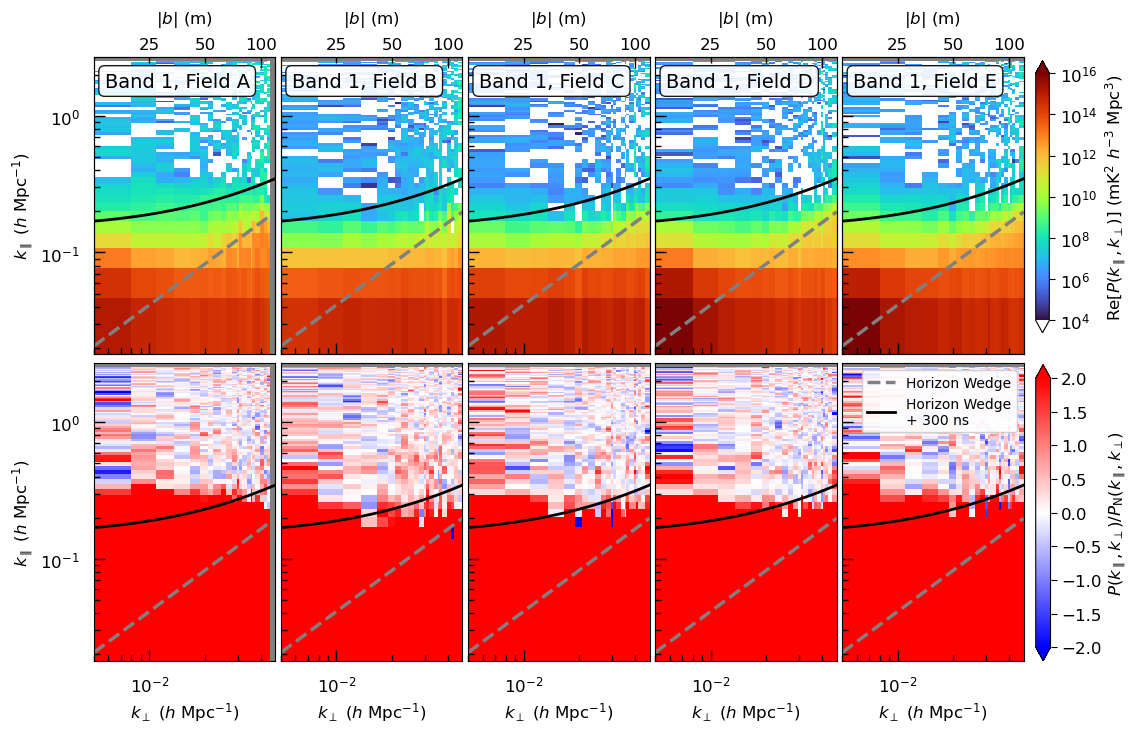

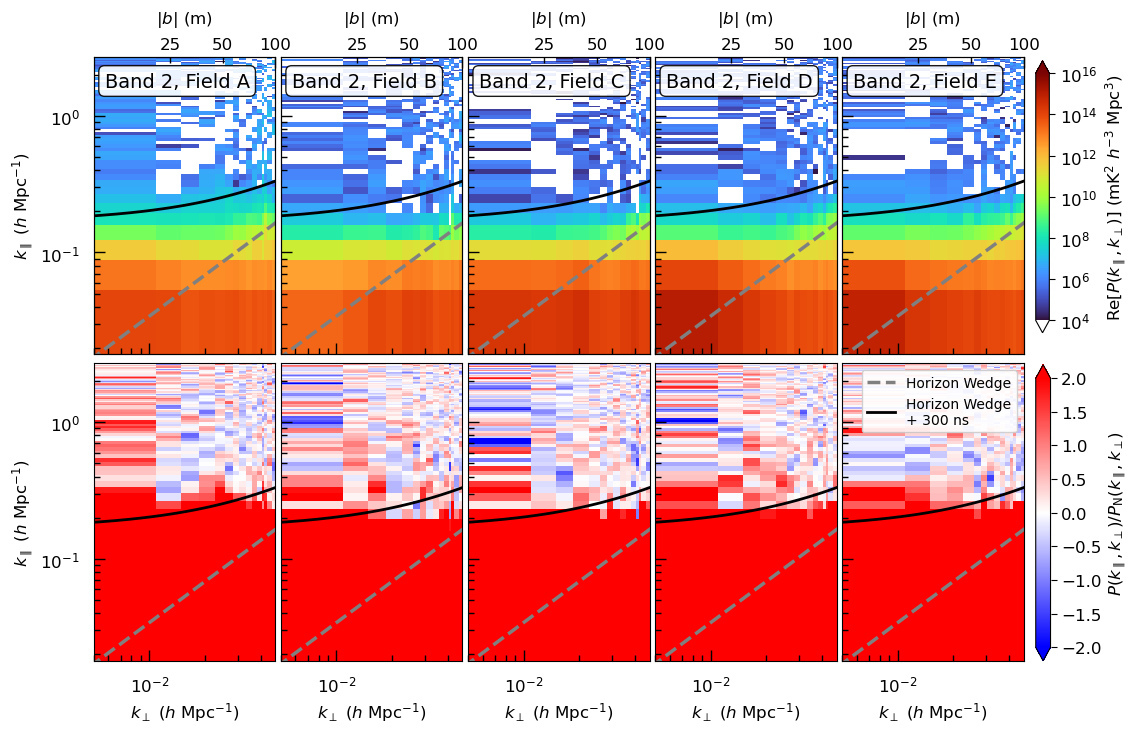

In [18]:
# basic settings
component = 'real'
cmap1 = copy.copy(plt.get_cmap("turbo"))
cmap1.set_bad('w')
if 'abs' in component:
    cmap1.set_under(plt.cm.turbo([0])[0])
else:
    cmap1.set_under('w')
cmap2 = plt.get_cmap("bwr")

xlim = 0.005, 0.048
ylim = 0.018, 2.7

for spw in [0, 1]:

    fig, axes = plt.subplots(2, len(uvp_xtk_tavg), figsize=(12, 8), dpi=100)
    fig.subplots_adjust(wspace=0.03, hspace=0.03)


    for i in range(2):
        for j in range(len(uvp_xtk_tavg)):
            ax = axes[i, j]
            ax.axvspan(0, 1, 0, 1, color='grey', zorder=0)
            
            # select only baseline pairs with finite noise
            u = copy.deepcopy(uvp_xtk_tavg[j])
            good_blps = set([])
            for key in u.get_all_keys():
                if key[0] == spw:
                    if np.all(np.isfinite(u.get_stats('P_N', key))):
                        good_blps.add(key[1])
            if len(good_blps) == 0:
                continue
            u.select(blpairs=sorted(good_blps))

            if i == 0:
                ax2, ax3 = wedge_plot(u, ax, spw, dly_label=False, cmap=cmap1, component=component, error_weights='P_N',
                                      xlim=xlim, ylim=ylim, twinx=False, twiny=True, fontsize=12, log10=False,
                                      norm=matplotlib.colors.LogNorm(vmin=1e4, vmax=1e16))
                ax2.set_xticks([100], minor=False); ax2.set_xticklabels([100], minor=False, fontsize=12)
                ax2.set_xticks([25, 50, 100], minor=True); ax2.set_xticklabels([25, 50, 100], minor=True, fontsize=12)
            else:
                u.data_array[spw] /= u.stats_array['P_N'][spw].real
                ax2, ax3 = wedge_plot(u, ax, spw, dly_label=False, cmap=cmap2, component=component, log10=False,
                                      xlim=xlim, ylim=ylim, fontsize=12, twinx=False, twiny=False, vmin=-2, vmax=2)
            ax.tick_params(labelsize=12)
            if j > 0:
                ax.set_yticklabels([])
                ax.set_ylabel('')
            if i == 0:
                ax.set_xticklabels([])
                ax.set_xlabel('')
            if i == 0:
                ax.text(0.06, 0.9, "Band {}, Field {}".format(spw+1, "ABCDEFGHIJ"[fields_used[j]]), fontsize=14, transform=ax.transAxes, 
                        color='k', bbox=dict(facecolor='w', alpha=0.9, boxstyle='round'))
            
          
            # plot buffer
            x = np.linspace(5, 120)  # meters
            z = u.cosmo.f2z(np.mean(u.get_spw_ranges(spw)[0][:2]))
            
            y = 1e9 / scipy.constants.c * x  # ns
            kperp, kpara = x * u.cosmo.bl_to_kperp(z, little_h=True), y * u.cosmo.tau_to_kpara(z, little_h=True) / 1e9
            ax.plot(kperp, kpara, c='grey', ls='--', lw=2.5, label='Horizon Wedge')
            
            y = 1e9 / scipy.constants.c * x + wedge_buff_ns  # ns
            kperp, kpara = x * u.cosmo.bl_to_kperp(z, little_h=True), y * u.cosmo.tau_to_kpara(z, little_h=True) / 1e9
            ax.plot(kperp, kpara, c='k', lw=2, label=f'Horizon Wedge\n+ {wedge_buff_ns} ns')
            
            if i == 1 and j == 4:
                ax.legend(framealpha=.9, fontsize=10, loc='upper right')

        if i == 0:
            cbax = fig.add_axes([0.825, 0.535, 0.1, 0.34])
        else:
            cbax = fig.add_axes([0.825, 0.125, 0.1, 0.37])
        cbax.axis('off')
        cax = ax.collections[0]
        extend = 'both' if i == 0 else 'both'
        cbar = fig.colorbar(cax, ax=cbax, extend=extend)
        cbar.ax.tick_params(labelsize=12, direction='out', size=4)
        if i== 0:
            cbar.set_label(r"Re$[P(k_\parallel, k_\perp)]\ ({\rm mK}^2\ h^{-3}\ {\rm Mpc}^3)$", fontsize=12)#, labelpad=8)
            cbar.ax.set_xlabel("$< 0$", labelpad=2, fontsize=12)
        else:
            cbar.set_label(r"$P(k_\parallel, k_\perp) / P_{\rm N}(k_\parallel,k_\perp)$", fontsize=12)#, labelpad=15)
    
    plt.savefig(f'Cylindrical_Pk_Band_{spw+1}.png', dpi=300, bbox_inches='tight')

# 1D Power Spectra

In [19]:
uvp_xtk_dsq_1 = []
uvp_xtk_dsq_2 = []
for field in 'ABCDE':
    uvp = hera_pspec.UVPSpec()
    uvp.read_hdf5(f'../All_Epochs_Power_Spectra/results_files/Deltasq_Band_1_Field_{field}.h5')
    uvp_xtk_dsq_1.append(uvp)
    
    uvp = hera_pspec.UVPSpec()
    uvp.read_hdf5(f'../All_Epochs_Power_Spectra/results_files/Deltasq_Band_2_Field_{field}.h5')
    uvp_xtk_dsq_2.append(uvp)
    

divide by zero encountered in true_divide
invalid value encountered in subtract
invalid value encountered in subtract
divide by zero encountered in true_divide
invalid value encountered in subtract
invalid value encountered in subtract


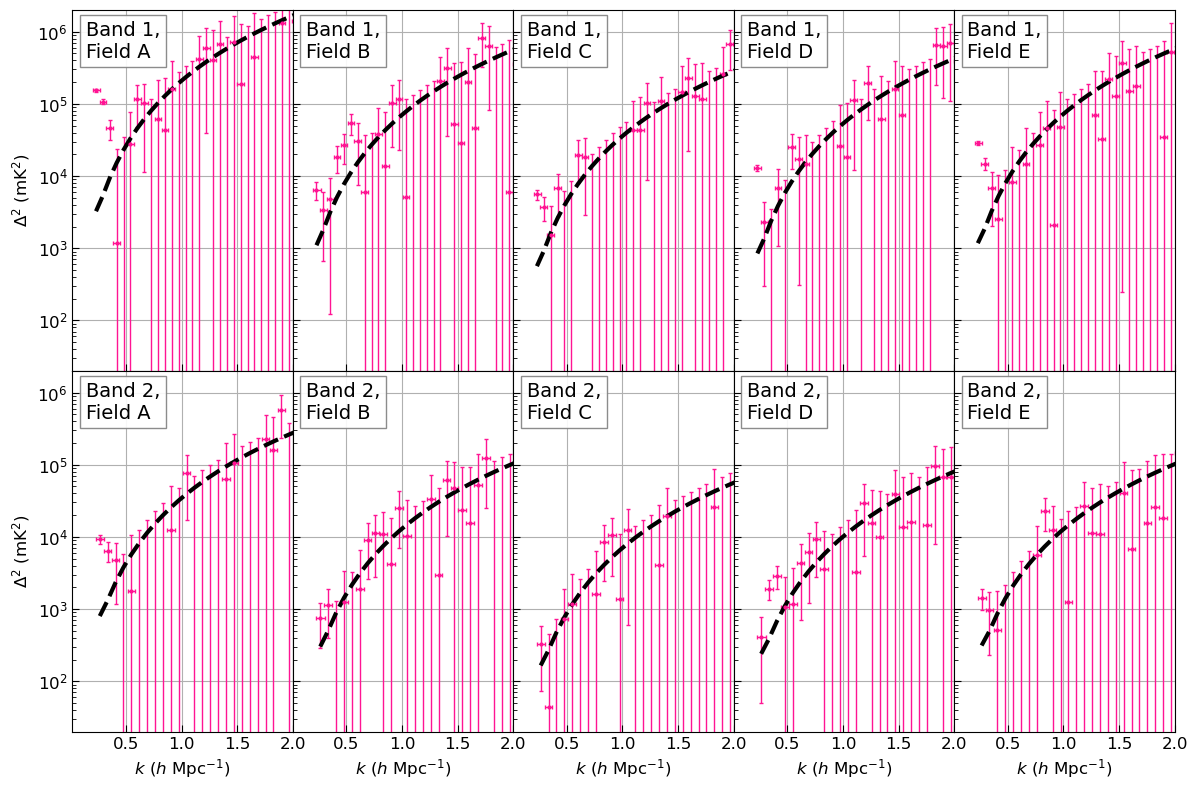

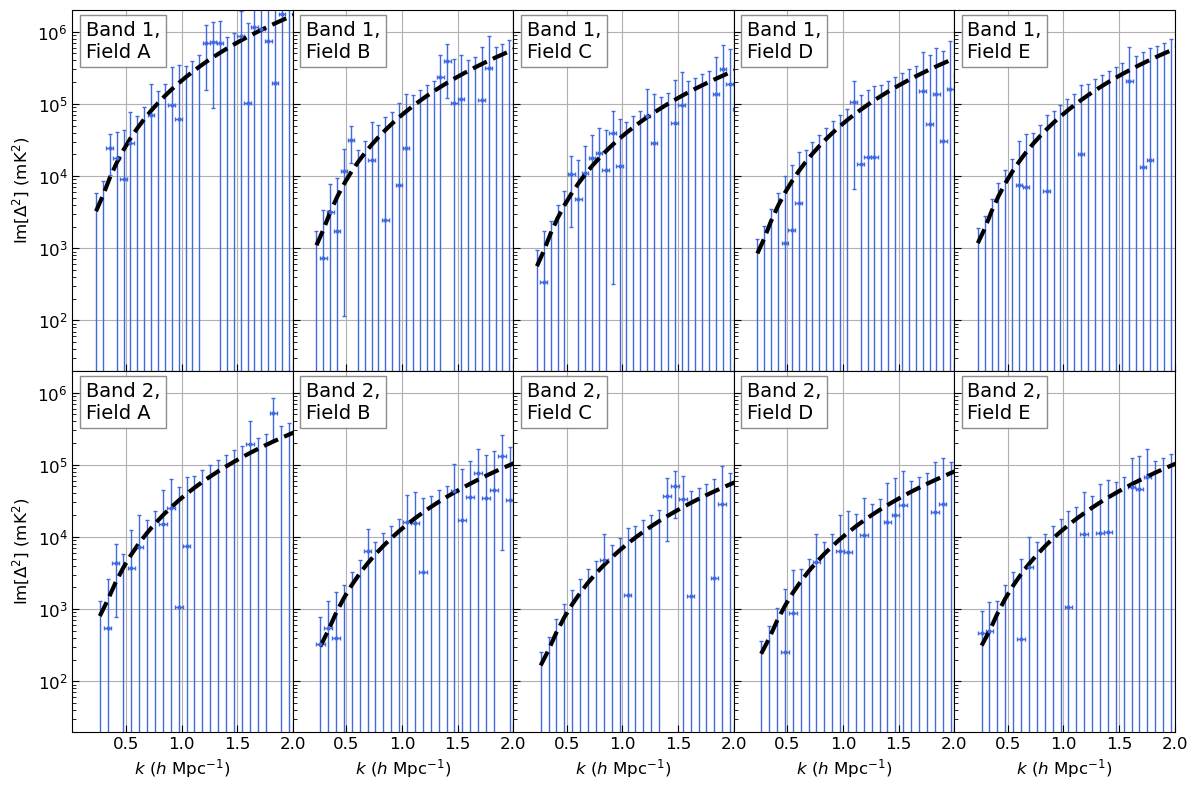

In [125]:
xlim = .02, 2
ylim = 2e1, 2e6

# loop over real and imaginary power spectra
for func, c in [(np.real, 'deeppink'), (np.imag, 'royalblue')]:
    fig, axes = plt.subplots(2, len(uvp_xtk_dsq_1),figsize=(12, 8), dpi=100, gridspec_kw={'hspace': 0, 'wspace': 0})
    fig.subplots_adjust(wspace=0.05, hspace=0.05)

    for i in range(2):
        uvp_xtk_dsq = [uvp_xtk_dsq_1, uvp_xtk_dsq_2][i]
        for j in range(len(uvp_xtk_dsq)):
            # get data
            ax = axes[i, j]
            u = uvp_xtk_dsq[j]
            spw = 0#i because we're loading only one band into each object
            
            kp = uvp_xtk_dsq[j].get_kparas(spw)
            ks = slice(np.argmin(np.abs(kp - 0.128)), None, 1)
            
            # get power spectra and vertical error bars
            y = func(u.data_array[spw].squeeze().copy()[ks].copy())
            y[y < 0] *= 0
            yerr = np.sqrt(np.diagonal(u.cov_array_real[spw].squeeze()))[ks]
            pn = u.stats_array['P_N'][spw].real.squeeze()[ks]
            pn[pn <= 0] = np.nan
            kbins = u.get_kparas(spw)
            k = kbins[ks]
            z = u.cosmo.f2z(np.mean(u.get_spw_ranges()[spw][:2]))       

            # get x errorbars from window func
            x, xerr_low, xerr_hi = sqe.utils.interp_Wcdf(u.window_function_array[spw].squeeze(), kbins)
            xerr = np.array([xerr_low, xerr_hi]).T[ks]
            # plot data
            p1 = ax.errorbar(k, y, marker='o', ms=2, ls='', capsize=1.5,
                             yerr=yerr * 2, c=c, xerr=xerr.T, lw=1)
            p2, = ax.plot(k, pn, c='k', ls='--', lw=3)

            # handle subplot
            ax.tick_params(labelsize=12, direction='in', size=5)
            ax.tick_params(direction='in', size=3, which='minor')
            ax.set_yscale('log')
            ax.grid()
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.text(0.06, 0.97, "Band {},\nField {}".format(i+1, "ABCDEFGHIJ"[fields_used[j]]), fontsize=14,
                    transform=ax.transAxes, bbox=dict(fc='w', ec='grey', alpha=0.9), va='top', ha='left')
            if i == 0:
                ax.set_xticklabels([])
            else:
                ax.set_xlabel(r"$k\ (h\ {\rm Mpc}^{-1})$", fontsize=12)
            if j == 0:
                if func == np.real:
                    ax.set_ylabel(r"$\Delta^2\ ({\rm mK}^2)$", fontsize=12)
                else:
                    ax.set_ylabel(r"Im$[\Delta^2]\ ({\rm mK}^2)$", fontsize=12)
            else:    
                ax.set_yticklabels([])
    
    plt.tight_layout()
    if func == np.imag:
        plt.savefig(f'all_imaginary_limits.pdf', dpi=200)
    else:
        plt.savefig(f'all_limits.pdf', dpi=200)

False


divide by zero encountered in true_divide
invalid value encountered in subtract
invalid value encountered in subtract


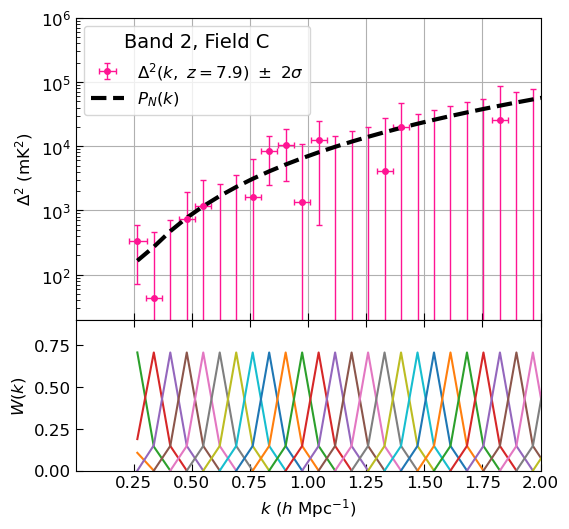

In [129]:
fig = plt.figure(figsize=(6, 6), dpi=100)
fig.subplots_adjust(hspace=0.0)

# set params
plot_window = True
component = 'real'
field = 2 # C
spw = 1


uvp_xtk_dsq = [uvp_xtk_dsq_1, uvp_xtk_dsq_2][spw]
i = 0#spw # because these objects were already split and thus have only one spw
u = uvp_xtk_dsq[fields_used.index(field)]
print(u.exact_windows)
kp = u.get_kparas(i)
ks = slice(np.argmin(np.abs(kp - 0.128)), None, 1)
c = 'deeppink'

# get data
y = u.data_array[i].real.squeeze().copy()[ks].copy()
y[y < 0] *= 0
yerr = np.sqrt(u.cov_array_real[i].squeeze().diagonal())[ks]
pn = u.stats_array['P_N'][i].real.squeeze()[ks]
pn[pn <= 0] = np.nan
kbins = u.get_kparas(i)
k = kbins[ks]
z = u.cosmo.f2z(np.mean(u.get_spw_ranges()[i][:2]))
xlim = 1e-4, 2

# get x errorbars from window func
x, xerr_low, xerr_hi = sqe.utils.interp_Wcdf(u.window_function_array[i].squeeze(), kbins)
xerr = np.array([xerr_low, xerr_hi]).T[ks]

grid = gridspec.GridSpec(3, 3)
if plot_window:
    ax = fig.add_subplot(grid[:2, :])
else:
    ax = fig.add_subplot(grid[:, :])

if component == 'abs-real':
    p1 = ax.errorbar(k, np.abs(y), marker='o', ms=4, ls='', yerr=yerr * 2, c=c, capsize=2)
else:
    p1 = ax.errorbar(k, np.real(y), marker='o', ms=4, ls='', capsize=2,
                     yerr=yerr * 2, c=c, xerr=xerr.T, lw=1)

p2, = ax.plot(k, pn, c='k', ls='--', lw=3)

ax.tick_params(labelsize=12, direction='in', size=5)
ax.tick_params(direction='in', size=3, which='minor')
ax.set_yscale('log')
ax.grid()
ax.set_xlim(xlim)
ax.set_ylim(2e1, 1e6)
ax.legend([p1, p2], [r'$\Delta^2(k,\ z={:.1f})\ \pm\ 2\sigma$'.format(z), r'$P_N(k)$'],
          fontsize=12, loc=2, ncol=1, title=f'Band {spw+1}, Field {"ABCDEFGHIJ"[field]}', title_fontsize=14)
if not plot_window:
    ax.set_xlabel(r'$k\ (h\ {\rm Mpc}^{-1}$)', fontsize=12)
else:
    ax.set_xticklabels([])
ax.set_ylabel(r'$\Delta^2\ ({\rm mK}^2)$', fontsize=12)

if plot_window:
    ax = fig.add_subplot(grid[2:, :])
    ax.tick_params(labelsize=12, direction='in', size=5, top=True, bottom=True)
    for win in u.window_function_array[i].squeeze()[:, ks].T:
        ax.plot(kbins, np.where(win < 1e-4, np.nan, win), lw=1.5)
    ax.set_xlim(xlim)
    ax.set_ylim(0, 0.9)
    ax.set_yticks([0, .25, .5, .75])
    ax.set_xlabel(r'$k\ (h\ {\rm Mpc}^{-1}$)', fontsize=12)
    ax.set_ylabel(r"$W(k)$", fontsize=12)
    #ax.set_yscale('log')
    
plt.savefig(f'limits_band_{spw+1}_field_{"ABCDEFGHIJ"[field]}.pdf', dpi=200)

In [22]:
max_k = 1

for spw in [0, 1]:

    uvp_xtk_dsq = [uvp_xtk_dsq_1, uvp_xtk_dsq_2][spw]
    i = 0#spw
    table_created = False
    for field in range(len(uvp_xtk_dsq)):
        ks = uvp_xtk_dsq[field].get_kparas(i)
        deltasq = uvp_xtk_dsq[field].data_array[i].squeeze().copy().real
        deltasq_err = np.sqrt(uvp_xtk_dsq[field].cov_array_real[i].squeeze().diagonal())
        deltasq_ul = np.array([dsq if dsq > 0 else 0 for dsq in deltasq]) + 2 * deltasq_err

        to_use = (ks <= max_k) & (deltasq_err > 0)
        if len(deltasq_ul[to_use]) == 0:
            continue
        
        if not table_created:
            table = np.vstack([deltasq[to_use], deltasq_err[to_use], deltasq_ul[to_use]])
            table_created = True
        else:
            table = np.vstack([table, deltasq[to_use], deltasq_err[to_use], deltasq_ul[to_use]])

    df = pd.DataFrame(table.T)

    col_ix = pd.MultiIndex.from_product([[f'Field {"ABCDEFGHIJ"[field]}' for field in fields_used], 
                                         ['$\Delta^{2}(k)$', '$1\sigma$', '$\Delta^{2}_{UL}$']]) 
    df.columns = col_ix
    df.insert(0, r"$k\ [h\ {\rm Mpc}^{-1}]$", ks[to_use])

    def css_border(x):
        return ["border-left: 1px solid black" if (i%3==1) else "border: 0px" for i, col in enumerate(x)]
    display(HTML(f'<h2>Band {spw+1}:</h2>'))
    
    to_display = df.style.hide_index() \
                   .format("{:,.2f}") \
                   .apply(css_border, axis=1) \
                   .set_properties(width='80px')
    
    display(HTML(to_display.render()))

In [23]:
# Print LaTeX to copy-paste into document
kmax = .65

for spw in [0, 1]:

    uvp_xtk_dsq = [uvp_xtk_dsq_1, uvp_xtk_dsq_2][spw]
    i = 0#spw
    table_created = False
    for field in range(len(uvp_xtk_dsq)):
        ks = uvp_xtk_dsq[field].get_kparas(0)
        deltasq = uvp_xtk_dsq[field].data_array[0].squeeze().copy().real
        deltasq_err = np.sqrt(uvp_xtk_dsq[field].cov_array_real[0].squeeze().diagonal())
        deltasq_ul = np.array([dsq if dsq > 0 else 0 for dsq in deltasq]) + 2 * deltasq_err
        
        to_use = (ks < kmax) & (deltasq_err > 0)
        if len(deltasq_ul[to_use]) == 0:
            continue
        
        print(f'% Band {spw+1}, Field {"ABCDEFGHIJ"[field]}')
        print('\n'.join([r'\multicolumn{1}{c}{} &',
                 r'\multicolumn{3}{c}{\textbf{Field ' + "ABCDEFGHIJ"[field] +r'}} \\',
                 r'\cmidrule(lr){2-4}',
                 r'\multicolumn{1}{c}{$k$ $(h\ {\rm Mpc}^{-1})$} &',
                 r'\multicolumn{1}{c}{$\Delta^2$ $({\rm mK})^2$} &',
                 r'\multicolumn{1}{c}{$1\sigma$ $({\rm mK})^2$} &',
                 r'\multicolumn{1}{c}{$\Delta^2_{\rm UL}$ $({\rm mK})^2$} \\',
                 r'\midrule']))
        for k, dsq, dsqerr, dsqul in zip(ks[to_use], deltasq[to_use], deltasq_err[to_use], deltasq_ul[to_use]):
            print(f'{k:.2f} & {dsq:,.1f} & {dsqerr:,.1f} & {dsqul:,.1f} \\\\')
        
        if field + 1 < len(uvp_xtk_dsq):
            print('')
            print(r'\cmidrule(lr){1-4}')
            print('')
        
    print('\n\n\n')

% Band 1, Field A
\multicolumn{1}{c}{} &
\multicolumn{3}{c}{\textbf{Field A}} \\
\cmidrule(lr){2-4}
\multicolumn{1}{c}{$k$ $(h\ {\rm Mpc}^{-1})$} &
\multicolumn{1}{c}{$\Delta^2$ $({\rm mK})^2$} &
\multicolumn{1}{c}{$1\sigma$ $({\rm mK})^2$} &
\multicolumn{1}{c}{$\Delta^2_{\rm UL}$ $({\rm mK})^2$} \\
\midrule
0.23 & 153,690.7 & 2,932.7 & 159,556.0 \\
0.29 & 107,666.9 & 4,270.6 & 116,208.0 \\
0.36 & 45,687.5 & 7,105.2 & 59,897.9 \\
0.42 & 1,182.1 & 11,336.1 & 23,854.3 \\
0.48 & -6,755.7 & 17,230.9 & 34,461.8 \\
0.54 & 28,245.4 & 24,666.0 & 77,577.3 \\
0.60 & 115,542.8 & 33,997.2 & 183,537.3 \\

\cmidrule(lr){1-4}

% Band 1, Field B
\multicolumn{1}{c}{} &
\multicolumn{3}{c}{\textbf{Field B}} \\
\cmidrule(lr){2-4}
\multicolumn{1}{c}{$k$ $(h\ {\rm Mpc}^{-1})$} &
\multicolumn{1}{c}{$\Delta^2$ $({\rm mK})^2$} &
\multicolumn{1}{c}{$1\sigma$ $({\rm mK})^2$} &
\multicolumn{1}{c}{$\Delta^2_{\rm UL}$ $({\rm mK})^2$} \\
\midrule
0.23 & 6,413.7 & 877.6 & 8,168.9 \\
0.29 & 3,352.4 & 1,342.8 & 6,038.0

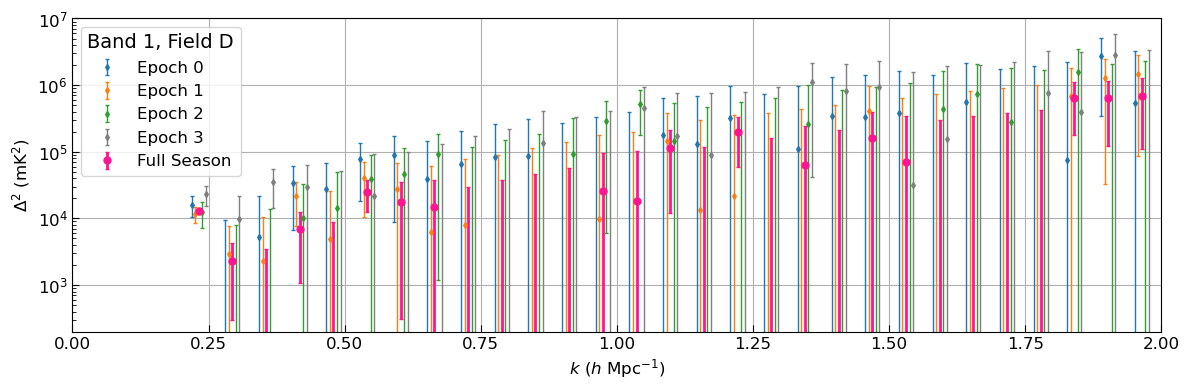

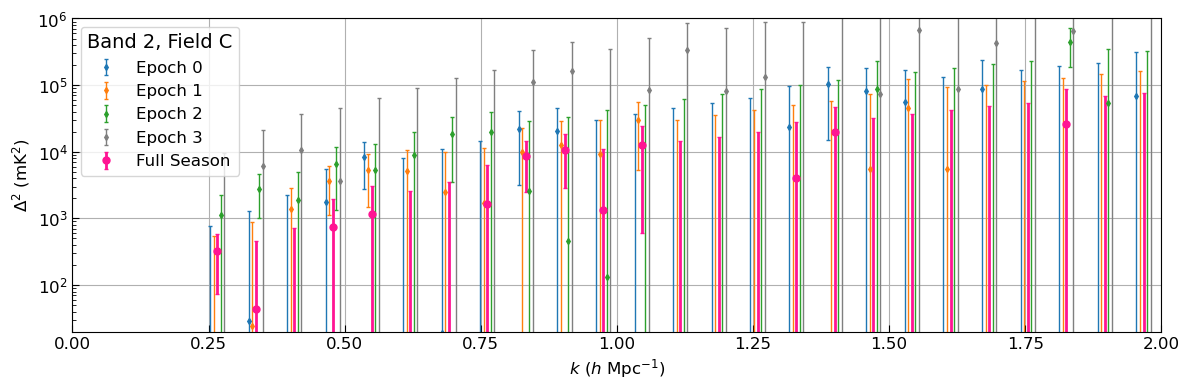

In [132]:
for spw, field, ylim in zip([0, 1], [3, 2], [(2e2, 1e7), (2e1, 1e6)]):

    fig = plt.figure(figsize=(12, 4), dpi=100)
    fig.subplots_adjust(hspace=0.0)

    # set params
    plot_window = True
    component = 'real'


    epoch_folders = ['../../Epoch_0_Power_Spectra/', '../Epoch_1_Power_Spectra/', '../Epoch_2_Power_Spectra/', '../Epoch_3_Power_Spectra/']
    for i, folder in enumerate(epoch_folders):
        u = hera_pspec.UVPSpec()
        u.read_hdf5(folder + f'results_files/Deltasq_Band_{spw+1}_Field_{"ABCDE"[field]}.h5')

        kp = u.get_kparas(0)
        ks = slice(np.argmin(np.abs(kp - 0.128)), None, 1)
        c = 'deeppink'

        # get data
        y = u.data_array[0].real.squeeze().copy()[ks].copy()
        y[y < 0] *= 0
        yerr = np.sqrt(u.cov_array_real[0].squeeze().diagonal())[ks]
        pn = u.stats_array['P_N'][0].real.squeeze()[ks]
        pn[pn <= 0] = np.nan
        kbins = u.get_kparas(0)
        k = kbins[ks]
        z = u.cosmo.f2z(np.mean(u.get_spw_ranges()[0][:2]))

        offset_k = k + [-2, -1, 1, 2][i]*.0065

        p1 = plt.errorbar(offset_k, np.real(y), marker='d', ms=3, ls='', c=['C0', 'C1', 'C2', 'C7'][i], yerr=yerr * 2, lw=1, label=f'Epoch {i}', capsize=1.5)


    # get data
    uvp_xtk_dsq = [uvp_xtk_dsq_1, uvp_xtk_dsq_2][spw]
    u = uvp_xtk_dsq[fields_used.index(field)]
    y = u.data_array[0].real.squeeze().copy()[ks].copy()
    y[y < 0] *= 0
    yerr = np.sqrt(u.cov_array_real[0].squeeze().diagonal())[ks]
    pn = u.stats_array['P_N'][0].real.squeeze()[ks]
    pn[pn <= 0] = np.nan
    kbins = u.get_kparas(0)
    k = kbins[ks]
    z = u.cosmo.f2z(np.mean(u.get_spw_ranges()[0][:2]))
    p1 = plt.errorbar(k, np.real(y), marker='o', ms=5, ls='', c = 'deeppink', yerr=yerr * 2, lw=2, label=f'Full Season', capsize=1.5)

    plt.gca().tick_params(labelsize=12, direction='in', size=5)
    plt.gca().tick_params(direction='in', size=3, which='minor')
    plt.gca().set_yscale('log')
    plt.gca().grid()
    plt.gca().set_xlim([.00, 2])
    plt.gca().set_ylim(ylim)
    plt.gca().legend(loc='upper left', fontsize=12, ncol=1, title=f'Band {spw+1}, Field {"ABCDE"[field]}', title_fontsize=14)

    plt.gca().set_ylabel(r'$\Delta^2\ ({\rm mK}^2)$', fontsize=12)
    plt.gca().set_xlabel(r'$k\ (h\ {\rm Mpc}^{-1}$)', fontsize=12)

    plt.tight_layout()
    plt.savefig(f'multi_epoch_limits_band_{spw+1}_field_{"ABCDEFGHIJ"[field]}.pdf', dpi=200)

# Validation Plots

In [25]:
uvp_eor_K_sph_1 = hera_pspec.UVPSpec()
uvp_eor_K_sph_2 = hera_pspec.UVPSpec()
uvp_eor_TK_sph_1 = hera_pspec.UVPSpec()
uvp_eor_TK_sph_2 = hera_pspec.UVPSpec()
# TODO: find a permanent home for these
uvp_eor_K_sph_1.read_hdf5('/lustre/aoc/projects/hera/jsdillon/Validation/h1c_idr3_2_pspec_notebooks/uvp_eor_K_sph_1.h5') 
uvp_eor_K_sph_2.read_hdf5('/lustre/aoc/projects/hera/jsdillon/Validation/h1c_idr3_2_pspec_notebooks/uvp_eor_K_sph_2.h5') 
uvp_eor_TK_sph_1.read_hdf5('/lustre/aoc/projects/hera/jsdillon/Validation/h1c_idr3_2_pspec_notebooks/uvp_eor_TK_sph_1.h5') 
uvp_eor_TK_sph_2.read_hdf5('/lustre/aoc/projects/hera/jsdillon/Validation/h1c_idr3_2_pspec_notebooks/uvp_eor_TK_sph_2.h5') 

invalid value encountered in true_divide


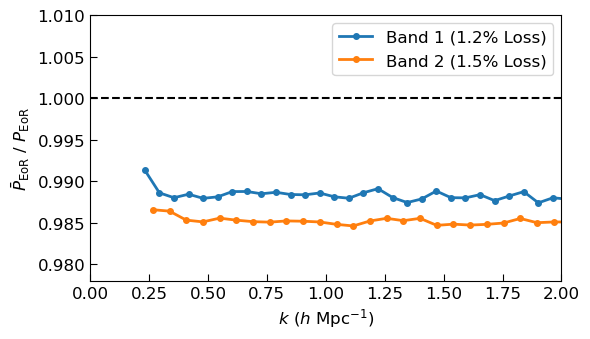

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(6,3.5), dpi=100)

ax.tick_params(labelsize=12, direction='in', size=5)
for band in range(2):
    uvp_eor_TK_sph = [uvp_eor_TK_sph_1, uvp_eor_TK_sph_2][band]
    uvp_eor_K_sph = [uvp_eor_K_sph_1, uvp_eor_K_sph_2][band]
    kbins = kbins = uvp_eor_K_sph.get_kparas(band)
    key = (band, uvp_eor_K_sph.get_blpairs()[0], 'pI')
    to_plot = uvp_eor_TK_sph.get_data(key).real[0] / uvp_eor_K_sph.get_data(key).real[0]
    p1, = ax.plot(kbins, to_plot, ls='-', marker='.', ms=8, lw=2, label=f'Band {band + 1} ({np.nanmean(1 - to_plot):.1%} Loss)')

ax.legend(fontsize=12)
ax.axhline(1, c='k', ls='--')
ax.set_xlim(.0, 2)
ax.set_ylim(0.978, 1.01)
# ax.grid()
ax.set_xlabel(r'$k\ (h\ {\rm Mpc}^{-1})$', fontsize=12)
ax.set_ylabel(r'$\bar{P}_{\rm EoR}\ /\ P_{\rm EoR}$', fontsize=12)
plt.tight_layout()

plt.savefig(f'time_averaging_signal_loss.pdf', dpi=200)

In [27]:
with open('/lustre/aoc/projects/hera/jsdillon/Validation/h1c_idr3_2_lstbin_notebooks/calibration_errors.p', 'rb') as f:
    combined_dict = pickle.load(f)

In [28]:
avg_relative_errors_true = combined_dict['avg_relative_errors_true']
avg_phase_error_true = combined_dict['avg_phase_error_true']
avg_relative_amp_error_true = combined_dict['avg_relative_amp_error_true']
avg_relative_errors_refl = combined_dict['avg_relative_errors_refl']
avg_phase_error_refl = combined_dict['avg_phase_error_refl']
avg_relative_amp_error_refl = combined_dict['avg_relative_amp_error_refl']
avg_amplitude_ratio_smooth_over_true = combined_dict['avg_amplitude_ratio_smooth_over_true']
avg_amplitude_ratio_smooth_over_refl = combined_dict['avg_amplitude_ratio_smooth_over_refl']
freqs = combined_dict['freqs']

Mean of empty slice
Mean of empty slice


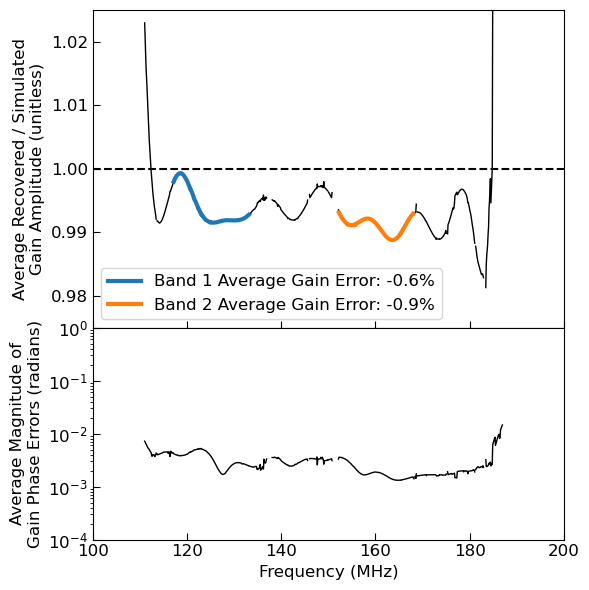

In [29]:
fig, ax = plt.subplots(2,1, figsize=(6,6), dpi=100, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios': [1.5,1]})

avg_amp_err = np.nanmean(list(avg_amplitude_ratio_smooth_over_true.values()), axis=0)
ax[0].plot(freqs/1e6, avg_amp_err, c='k', lw=1)
ax[0].plot(freqs[176:340]/1e6, avg_amp_err[176:340], c='C0', lw=3, label=f'Band 1 Average Gain Error: {(np.mean(avg_amp_err[176:340]) - 1):.1%}')
ax[0].plot(freqs[535:697]/1e6, avg_amp_err[535:697], c='C1', lw=3, label=f'Band 2 Average Gain Error: {(np.mean(avg_amp_err[535:697]) - 1):.1%}')

ax[0].set_ylabel('Average Recovered / Simulated\nGain Amplitude (unitless)', fontsize=12)
ax[0].axhline(1, c='k', ls='--')
ax[0].legend(fontsize=12)
ax[0].set_ylim([.975, 1.025])
ax[0].set_xlim([100, 200])
ax[0].tick_params(labelsize=12, direction='in', size=5)

ax[1].semilogy(freqs/1e6, np.nanmean(list(avg_phase_error_true.values()), axis=0), lw=1, c='k')


ax[1].set_ylabel('Average Magnitude of\nGain Phase Errors (radians)', fontsize=12)
ax[1].set_xlabel('Frequency (MHz)', fontsize=12)
ax[1].set_ylim([1e-4, 1])
ax[1].tick_params(labelsize=12, direction='in', size=5)

plt.tight_layout()
plt.savefig(f'validation_gain_errors.pdf', dpi=200)

In [30]:
with open('/lustre/aoc/projects/hera/jsdillon/Validation/h1c_idr3_2_lstbin_notebooks/calibration_bias_waterfalls.p', 'rb') as f:
    combined_dict = pickle.load(f)
JD = combined_dict['JD']
abs_ratio = combined_dict['abs_ratio']
smooth_ratio = combined_dict['smooth_ratio']
freqs = combined_dict['freqs']
time_grid = combined_dict['time_grid']

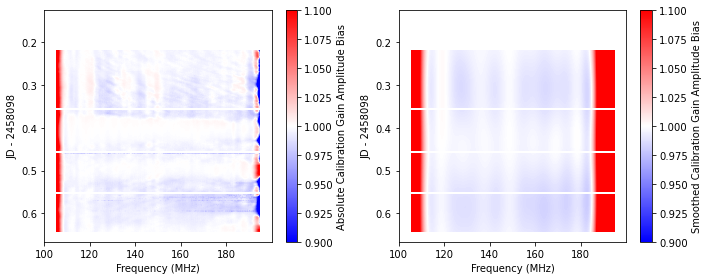

In [31]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(abs_ratio, aspect='auto', cmap='bwr',
           extent=[freqs[0]/1e6, freqs[-1]/1e6, time_grid[-1]-JD, time_grid[0]-JD])
plt.clim([.9,1.1])
plt.colorbar(label='Absolute Calibration Gain Amplitude Bias')
plt.xlabel('Frequency (MHz)')
plt.ylabel('JD - 2458098')

plt.subplot(122)
plt.imshow(smooth_ratio, aspect='auto', cmap='bwr',
           extent=[freqs[0]/1e6, freqs[-1]/1e6, time_grid[-1]-JD, time_grid[0]-JD])
plt.clim([.9,1.1])
plt.colorbar(label='Smoothed Calibration Gain Amplitude Bias')
plt.xlabel('Frequency (MHz)')
plt.ylabel('JD - 2458098')

plt.tight_layout()

In [32]:
eor_band_1 = hera_pspec.UVPSpec()
eor_band_2 = hera_pspec.UVPSpec()
true_sum_band_1 = hera_pspec.UVPSpec()
true_sum_band_2 = hera_pspec.UVPSpec()
# TODO: find a permanent home for these
eor_band_1.read_hdf5('/lustre/aoc/projects/hera/jsdillon/Validation/h1c_idr3_2_pspec_notebooks/P_of_kt_eor_band_1.h5') 
eor_band_2.read_hdf5('/lustre/aoc/projects/hera/jsdillon/Validation/h1c_idr3_2_pspec_notebooks/P_of_kt_eor_band_2.h5') 
true_sum_band_1.read_hdf5('/lustre/aoc/projects/hera/jsdillon/Validation/h1c_idr3_2_pspec_notebooks/P_of_kt_true_sum_band_1.h5') 
true_sum_band_2.read_hdf5('/lustre/aoc/projects/hera/jsdillon/Validation/h1c_idr3_2_pspec_notebooks/P_of_kt_true_sum_band_2.h5') 
lsts = np.load('/lustre/aoc/projects/hera/jsdillon/Validation/h1c_idr3_2_pspec_notebooks/xtalk_test_lsts.npz')['lsts']

invalid value encountered in true_divide
All-NaN slice encountered


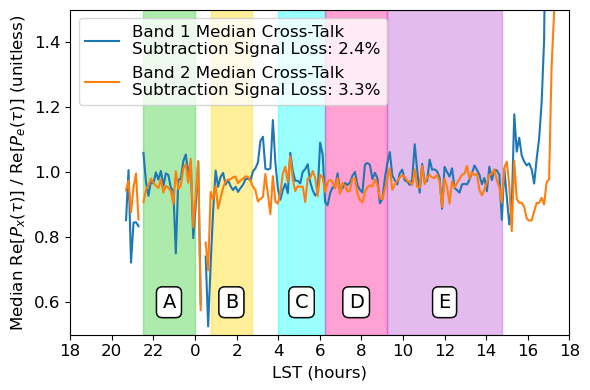

In [33]:
fig, ax = plt.subplots(1,1,figsize=(6,4), dpi=100, sharex=True, gridspec_kw={'hspace': 0})

for band, true_sum, eor, color in zip([1, 2], [true_sum_band_1, true_sum_band_2], [eor_band_1, eor_band_2], ['C0', 'C1']):
    ratio = np.real(np.squeeze(true_sum.data_array[0])) / np.real(np.squeeze(eor.data_array[0]))  
    subset = ratio[:, (eor.dly_array * 1e9 < 4000)]
    use_this_lst = np.zeros_like(lsts, dtype=bool)
    for field, (lc, c) in enumerate(zip(lstcuts, lst_colors)):
        use_this_lst[(lsts > lc[0]) & (lsts < lc[1])] = True
        ax.text(np.mean(lc), .6, f'{"ABCDEFGHIJ"[field]}', ha='center', va='center', fontsize=14, bbox=dict(facecolor='w', alpha=0.9, boxstyle='round'))
    ax.plot(lsts, np.nanmedian(subset, axis=1), c=color, 
            label=f'Band {band} Median Cross-Talk\nSubtraction Signal Loss: {1 - np.nanmedian(subset[use_this_lst]):.1%}')
    
for lc, c in zip(lstcuts, lst_colors):
    ax.axvspan(lc[0], lc[1], color=c, alpha=.4)    
ax.set_ylim([.5, 1.5])
ax.set_xticks(np.arange(-6, 20, 2), fontsize=12)
ax.set_xlim([-6,18])
ax.set_xticklabels(np.arange(-6, 20, 2) % 24, fontsize=12)
plt.gca().tick_params(labelsize=12)
plt.xlabel('LST (hours)', size=12)
plt.ylabel('Median Re$[P_{x}(\\tau)]$ / Re$[P_{e}(\\tau)]$ (unitless)', size=12)
plt.legend(fontsize=12, loc='upper left')
plt.tight_layout()
plt.savefig(f'validation_cross_talk_subtraction_signal_loss.pdf', dpi=200)

invalid value encountered in true_divide


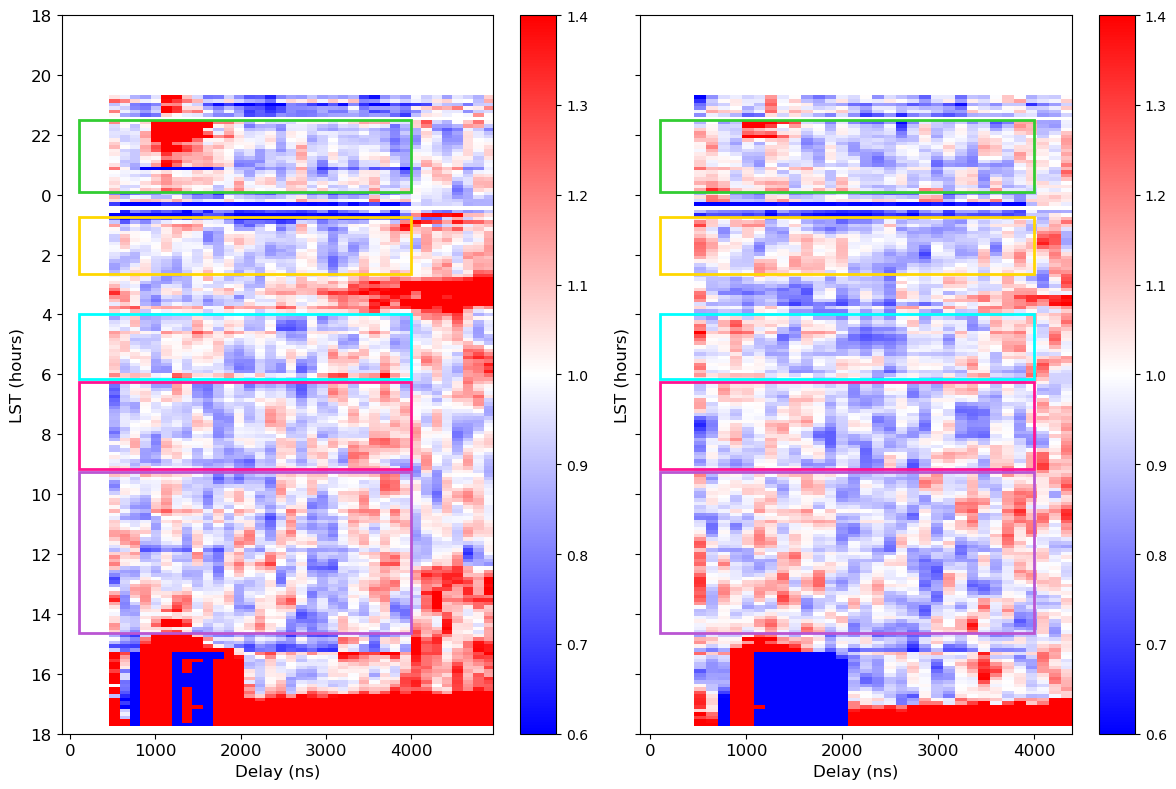

In [34]:
fix, axes = plt.subplots(1, 2,figsize=(12,8), dpi=100, sharey=True)
for ax, true_sum, eor in zip(axes, [true_sum_band_1, true_sum_band_2], [eor_band_1, eor_band_2]):

    extent = [eor.dly_array[0] * 1e9, eor.dly_array[-1] * 1e9, lsts[-1], lsts[0]]
    ratio = np.real(np.squeeze(true_sum.data_array[0])) / np.real(np.squeeze(eor.data_array[0]))
    im = ax.imshow(ratio, aspect='auto', interpolation='none', cmap='bwr', extent=extent, vmin=.6, vmax=1.4)
    plt.colorbar(im, ax=ax)
    for i, lc in enumerate(lstcuts):
        r = plt.Rectangle((110, lc[0]), 3890, lc[1]-lc[0]-.1, fc='None', ec=lst_colors[i], lw=2)
        ax.add_patch(r)
        
        subset = ratio[(lsts > lc[0]) & (lsts < lc[1])]
        subset = subset[:, (eor.dly_array * 1e9 < 4000)]
        ax.set_xlim(-100)
        ax.set_yticks(np.arange(-6, 20, 2))
        axes[0].set_yticklabels(np.arange(-6, 20, 2) % 24)
        ax.tick_params(labelsize=12)
        ax.set_xlabel('Delay (ns)', fontsize=12)
        ax.set_ylabel('LST (hours)', fontsize=12)        

plt.tight_layout()

# Non-Redundancy Signal Loss

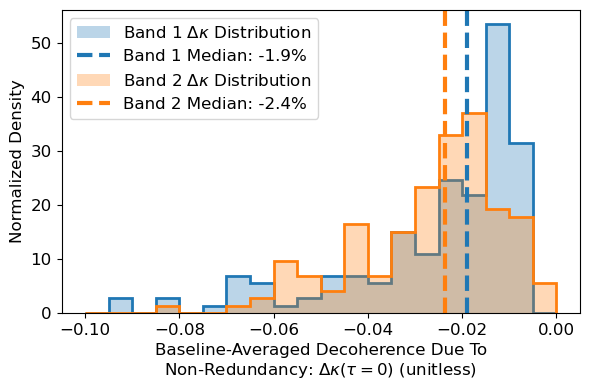

In [35]:
decorr_band_1, decorr_band_2 = np.load('decorrelation.npy')
decorr_band_1 = decorr_band_1[(decorr_band_1 != 0) & (np.isfinite(decorr_band_1))]
decorr_band_2 = decorr_band_2[(decorr_band_2 != 0) & (np.isfinite(decorr_band_2))]

plt.figure(figsize=(6,4), dpi=100)
bins = np.arange(-.1, 0.005, .005)
plt.hist(decorr_band_1, density=True, bins=bins, histtype='stepfilled', alpha=.3, color='C0', label='Band 1 $\Delta \kappa$ Distribution', zorder=1)
plt.hist(decorr_band_1, density=True, bins=bins, histtype='step', color='C0', lw=2, zorder=1)
plt.axvline(np.median(decorr_band_1), ls='--', lw=3, color='C0', label=f'Band 1 Median: {np.median(decorr_band_1):.1%}', zorder=2)

plt.hist(decorr_band_2, density=True, bins=bins, histtype='stepfilled', alpha=.3, color='C1', label='Band 2 $\Delta \kappa$ Distribution', zorder=1)
plt.hist(decorr_band_2, density=True, bins=bins, histtype='step', color='C1', lw=2, zorder=1)
plt.axvline(np.median(decorr_band_2), ls='--', lw=3, color='C1', label=f'Band 2 Median: {np.median(decorr_band_2):.1%}', zorder=2)

plt.legend(fontsize=12)

# plt.hist(decorr_band_2, density=True, bins=bins, histtype='stepfilled', alpha=.5, color='C1')
plt.xlabel('Baseline-Averaged Decoherence Due To\nNon-Redundancy: $\Delta \kappa (\\tau = 0)$ (unitless)', fontsize=12)
plt.ylabel('Normalized Density', fontsize=12)
plt.gca().tick_params(labelsize=12)#, direction='in', size=5)

plt.tight_layout()
plt.savefig(f'non_redundancy_decoherence.pdf', dpi=200)